## Problem Statement

An education company named X Education sells online courses to industry professionals.The company markets its courses on several websites and search engines like Google.<br>

Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. <br>

Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. 
The average lead conversion rate is around 30%.
To make it more efficient,company needs to identify potential leads,who are more likely to convert,and the sales team can contact these potential lead instead of calling everyone.

### Business Goal

- Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. 
- A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.
- There are some more problems presented by the company which the model should be able to adjust to if the company's requirement changes in the future; so these need to be handled as well.


### Analysis Approach

1. Reading and understanding Data - basic inspection
2. Data Cleaning - Handling missing values, dropping unwanted columns
3. Perform Outlier treatment - capping or dropping
4. Data Preparation - perform EDA, one hot encoding(dummy variable creation), scaling and perform train test split - 
5. Modelling - RFE and manual approach (p value and VIF)
6. Performance on test data
7. Predict lead score using probabilty score
8. Conclusion

In [1]:
#---------- importing required librarires for initial analysis ---------- 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn

#---------- display options ---------- 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.options.display.float_format='{:.4f}'.format

sns.set_style("whitegrid")

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

#---------- filtering warnings ---------- 

import warnings
warnings.filterwarnings("ignore")

In [2]:
#reading the file to a dataframe called 'leads'

leads = pd.read_csv("leads.csv")

In [3]:
#checking first few rows

leads.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0       0.0000   
1  Organic Search           No          No          0       5.0000   
2  Direct Traffic           No          No          1       2.0000   
3  Direct Traffic           No          No          0       1.0000   
4          Google           No          No          1       2.0000   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                0.0000  Page Visited on Website   
1                          674                2.5000             Email Opened   
2                         1532                2.0000             Email Opened   
3                          305                1.0000              Unreachable   
4                         1428                1.0000        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

In [4]:
#checking daframe shape

leads.shape

#there are 9240 rows and 37 columns

(9240, 37)

In [5]:
#checking other info of dataframe

leads.info()

#at a glance, columns with null values can be spotted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [6]:
#checking statistical description

leads.describe()

#presence of outliers can be detected

#mean, min, max and all quantile values can be seeen

Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
count    9240.0000  9240.0000    9103.0000                    9240.0000   
mean   617188.4356     0.3854       3.4452                     487.6983   
std     23405.9957     0.4867       4.8549                     548.0215   
min    579533.0000     0.0000       0.0000                       0.0000   
25%    596484.5000     0.0000       1.0000                      12.0000   
50%    615479.0000     0.0000       3.0000                     248.0000   
75%    637387.2500     1.0000       5.0000                     936.0000   
max    660737.0000     1.0000     251.0000                    2272.0000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count             9103.0000                    5022.0000   
mean                 2.3628                      14.3063   
std                  2.1614                       1.3867   
min                  0.0000                       7.0000   
25%                  1.0000                      14.0000   
50%                  2.0000                      14.0000   
75%                  3.0000                      15.0000   
max                 55.0000                      18.0000   

       Asymmetrique Profile Score  
count                   5022.0000  
mean                      16.3449  
std                        1.8114  
min                       11.0000  
25%                       15.0000  
50%                       16.0000  
75%                       18.0000  
max                       20.0000

***Inference:<br>***
- The mean,standard deviation, minimum value,maximum value and the 25,50 and 75 percentile values of the numerical variables can be identified from the above data.
- In few of the columns there is a huge difference between the 75% value and the max value.This indicates the ***presence of possible outliers***.

In [7]:
#checking for duplicated values in the dataframe

leads[leads.duplicated(keep = False)]

Empty DataFrame
Columns: [Prospect ID, Lead Number, Lead Origin, Lead Source, Do Not Email, Do Not Call, Converted, TotalVisits, Total Time Spent on Website, Page Views Per Visit, Last Activity, Country, Specialization, How did you hear about X Education, What is your current occupation, What matters most to you in choosing a course, Search, Magazine, Newspaper Article, X Education Forums, Newspaper, Digital Advertisement, Through Recommendations, Receive More Updates About Our Courses, Tags, Lead Quality, Update me on Supply Chain Content, Get updates on DM Content, Lead Profile, City, Asymmetrique Activity Index, Asymmetrique Profile Index, Asymmetrique Activity Score, Asymmetrique Profile Score, I agree to pay the amount through cheque, A free copy of Mastering The Interview, Last Notable Activity]
Index: []

***Inference:<br>***
- No duplicate rows present.

#### DATA CLEANING: Dropping unwanted columns

In [8]:
# Removing the ID columns - Prospect ID and Lead Number ,since they do not help with the analysis.

# Removing Sales team generated columns since they won't be available at the time of running the model; hence cannot be 
#included in our regression model.

leads.drop(['Prospect ID','Lead Number','Tags','Lead Quality','Asymmetrique Activity Index','Asymmetrique Profile Index',
            'Asymmetrique Activity Score','Asymmetrique Profile Score','Last Activity','Last Notable Activity',
            'Lead Profile'], axis = 1, inplace = True)


In [9]:
#checking if the columns are dropped

leads.head()

Lead Origin     Lead Source Do Not Email Do Not Call  \
0                      API      Olark Chat           No          No   
1                      API  Organic Search           No          No   
2  Landing Page Submission  Direct Traffic           No          No   
3  Landing Page Submission  Direct Traffic           No          No   
4  Landing Page Submission          Google           No          No   

   Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0       0.0000                            0                0.0000   
1          0       5.0000                          674                2.5000   
2          1       2.0000                         1532                2.0000   
3          0       1.0000                          305                1.0000   
4          1       2.0000                         1428                1.0000   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

  Update me on Supply Chain Content Get updates on DM Content    City  \
0                                No                        No  Select   
1                                No                        No  Select   
2                                No                        No  Mumbai   
3                                No                        No  Mumbai   
4                                No                        No  Mumbai   

  I agree to pay the amount through cheque  \
0                                       No   
1                                       No   
2                                       No   
3                                       No   
4                                       No   

  A free copy of Mastering The Interview  
0                                     No  
1                                     No  
2                                    Yes  
3                                     No  
4                                     No

In [10]:
#changing value of categorical columns from 'select' to nan value.

#this is done because, as per the buisness problem, this value is as good as null.

leads = leads.replace('Select', np.nan)

***Data cleaning: Handling Missing values - Column wise***

In [11]:
#finding percentage of missing values and saving it to 'perc_miss'

perc_miss = 100*(leads.isnull().sum()/len(leads))

perc_miss

Lead Origin                                      0.0000
Lead Source                                      0.3896
Do Not Email                                     0.0000
Do Not Call                                      0.0000
Converted                                        0.0000
TotalVisits                                      1.4827
Total Time Spent on Website                      0.0000
Page Views Per Visit                             1.4827
Country                                         26.6342
Specialization                                  36.5801
How did you hear about X Education              78.4632
What is your current occupation                 29.1126
What matters most to you in choosing a course   29.3182
Search                                           0.0000
Magazine                                         0.0000
Newspaper Article                                0.0000
X Education Forums                               0.0000
Newspaper                                       

In [12]:
#looking for columns with more than 40% missing values and saving them back to 'miss40'

miss40 = perc_miss[perc_miss > 40]

miss40

How did you hear about X Education   78.4632
dtype: float64

In [13]:
#dropping columns with more than 40% missing values

leads.drop(labels=miss40.index, axis = 1, inplace = True)

In [14]:
leads.shape

#number of columns reduced from 37 to 25. total 12 columns dropped by now.

(9240, 25)

#### Data Cleaning: Handling / Imputation of null values in categorical columns

In [15]:
#defining a function to print value counts and sum of null values AND mode value of all categorical column

def check_cate(col):
    
    print("\033[1mCount of each value in "+col+": \033[0m")
    print(leads[col].value_counts(normalize=True))
    
    print("\n")
    
    print("\033[1mTotal number of nan value in "+col+" column: \033[0m",leads[col].isnull().sum())
    
    print("\n")
    
    print("\033[1mPercentage of missing values in "+col+" column: \033[0m",round(100*(leads[col].isnull().sum()/len(leads)),4))
    
    print("\n")
    
    print("\033[1mMode value in "+col+" column is: \033[0m",leads[col].mode()[0])

In [16]:
check_cate("Lead Origin")

#no null values, no data skeweness

Count of each value in Lead Origin: 
Landing Page Submission   0.5288
API                       0.3874
Lead Add Form             0.0777
Lead Import               0.0060
Quick Add Form            0.0001
Name: Lead Origin, dtype: float64


Total number of nan value in Lead Origin column:  0


Percentage of missing values in Lead Origin column:  0.0


Mode value in Lead Origin column is:  Landing Page Submission


In [17]:
check_cate("Lead Source")

Count of each value in Lead Source: 
Google              0.3116
Direct Traffic      0.2763
Olark Chat          0.1907
Organic Search      0.1254
Reference           0.0580
Welingak Website    0.0154
Referral Sites      0.0136
Facebook            0.0060
bing                0.0007
google              0.0005
Click2call          0.0004
Live Chat           0.0002
Social Media        0.0002
Press_Release       0.0002
Pay per Click Ads   0.0001
welearnblog_Home    0.0001
blog                0.0001
youtubechannel      0.0001
NC_EDM              0.0001
testone             0.0001
WeLearn             0.0001
Name: Lead Source, dtype: float64


Total number of nan value in Lead Source column:  36


Percentage of missing values in Lead Source column:  0.3896


Mode value in Lead Source column is:  Google


In [18]:
# Imputing the null values with the mode value as displayed above

leads['Lead Source'] = leads['Lead Source'].fillna(leads['Lead Source'].mode()[0])


In [19]:
#categorizing different fileds for easy analysis

#replacing value 'google' as 'Google'

leads['Lead Source'] = leads['Lead Source'].replace('google', 'Google')

#Grouping less percentage values to "Others"

leads['Lead Source'] = leads['Lead Source'].replace(['Live Chat', 'Press_Release', 'Social Media', 'Pay per Click Ads', 
                                                     'welearnblog_Home', 'testone', 'NC_EDM', 'youtubechannel', 'blog', 
                                                     'WeLearn'], 'Others')

In [20]:
#checking leads source column again after imputation

check_cate("Lead Source")

Count of each value in Lead Source: 
Google             0.3148
Direct Traffic     0.2752
Olark Chat         0.1899
Organic Search     0.1249
Reference          0.0578
Welingak Website   0.0154
Referral Sites     0.0135
Facebook           0.0060
Others             0.0014
bing               0.0006
Click2call         0.0004
Name: Lead Source, dtype: float64


Total number of nan value in Lead Source column:  0


Percentage of missing values in Lead Source column:  0.0


Mode value in Lead Source column is:  Google


In [21]:
check_cate("Do Not Email")

#no null values

Count of each value in Do Not Email: 
No    0.9206
Yes   0.0794
Name: Do Not Email, dtype: float64


Total number of nan value in Do Not Email column:  0


Percentage of missing values in Do Not Email column:  0.0


Mode value in Do Not Email column is:  No


In [22]:
#since 92% of data is skewed, dropping this column

leads.drop("Do Not Email", axis = 1, inplace = True)

In [23]:
check_cate("Do Not Call")

Count of each value in Do Not Call: 
No    0.9998
Yes   0.0002
Name: Do Not Call, dtype: float64


Total number of nan value in Do Not Call column:  0


Percentage of missing values in Do Not Call column:  0.0


Mode value in Do Not Call column is:  No


In [24]:
#since 99.98% of data is skewed, dropping this column

leads.drop("Do Not Call", axis = 1, inplace = True)

In [25]:
check_cate("Country")

Count of each value in Country: 
India                  0.9577
United States          0.0102
United Arab Emirates   0.0078
Singapore              0.0035
Saudi Arabia           0.0031
United Kingdom         0.0022
Australia              0.0019
Qatar                  0.0015
Hong Kong              0.0010
Bahrain                0.0010
France                 0.0009
Oman                   0.0009
unknown                0.0007
South Africa           0.0006
Nigeria                0.0006
Canada                 0.0006
Germany                0.0006
Kuwait                 0.0006
Sweden                 0.0004
Bangladesh             0.0003
Uganda                 0.0003
Ghana                  0.0003
Belgium                0.0003
Netherlands            0.0003
Philippines            0.0003
Asia/Pacific Region    0.0003
Italy                  0.0003
China                  0.0003
Kenya                  0.0001
Liberia                0.0001
Denmark                0.0001
Switzerland            0.0001
Vietnam

In [26]:
#since this column is skewed (95% of value is 'India' ), dropping Country column

leads.drop('Country', axis = 1, inplace = True)

In [27]:
check_cate("Specialization")

Count of each value in Specialization: 
Finance Management                  0.1666
Human Resource Management           0.1447
Marketing Management                0.1430
Operations Management               0.0858
Business Administration             0.0688
IT Projects Management              0.0625
Supply Chain Management             0.0596
Banking, Investment And Insurance   0.0577
Media and Advertising               0.0346
Travel and Tourism                  0.0346
International Business              0.0304
Healthcare Management               0.0271
Hospitality Management              0.0195
E-COMMERCE                          0.0191
Retail Management                   0.0171
Rural and Agribusiness              0.0125
E-Business                          0.0097
Services Excellence                 0.0068
Name: Specialization, dtype: float64


Total number of nan value in Specialization column:  3380


Percentage of missing values in Specialization column:  36.5801


Mode value in Special

In [28]:
#since filling 36% of data with mode value result in exaggeration of data, imputing null values with "Others"

leads.Specialization = leads.Specialization.fillna("Others")

In [29]:
#checking specalization column again

check_cate("Specialization")

Count of each value in Specialization: 
Others                              0.3658
Finance Management                  0.1056
Human Resource Management           0.0918
Marketing Management                0.0907
Operations Management               0.0544
Business Administration             0.0436
IT Projects Management              0.0396
Supply Chain Management             0.0378
Banking, Investment And Insurance   0.0366
Media and Advertising               0.0220
Travel and Tourism                  0.0220
International Business              0.0193
Healthcare Management               0.0172
Hospitality Management              0.0123
E-COMMERCE                          0.0121
Retail Management                   0.0108
Rural and Agribusiness              0.0079
E-Business                          0.0062
Services Excellence                 0.0043
Name: Specialization, dtype: float64


Total number of nan value in Specialization column:  0


Percentage of missing values in Specialization 

In [30]:
check_cate("What is your current occupation")

Count of each value in What is your current occupation: 
Unemployed             0.8550
Working Professional   0.1078
Student                0.0321
Other                  0.0024
Housewife              0.0015
Businessman            0.0012
Name: What is your current occupation, dtype: float64


Total number of nan value in What is your current occupation column:  2690


Percentage of missing values in What is your current occupation column:  29.1126


Mode value in What is your current occupation column is:  Unemployed


In [31]:
#imputing null values with mode value

leads["What is your current occupation"] = leads["What is your current occupation"].fillna(leads['What is your current occupation'].mode()[0])


In [32]:
check_cate("What is your current occupation")

Count of each value in What is your current occupation: 
Unemployed             0.8972
Working Professional   0.0764
Student                0.0227
Other                  0.0017
Housewife              0.0011
Businessman            0.0009
Name: What is your current occupation, dtype: float64


Total number of nan value in What is your current occupation column:  0


Percentage of missing values in What is your current occupation column:  0.0


Mode value in What is your current occupation column is:  Unemployed


In [33]:
check_cate("What matters most to you in choosing a course")

Count of each value in What matters most to you in choosing a course: 
Better Career Prospects     0.9995
Flexibility & Convenience   0.0003
Other                       0.0002
Name: What matters most to you in choosing a course, dtype: float64


Total number of nan value in What matters most to you in choosing a course column:  2709


Percentage of missing values in What matters most to you in choosing a course column:  29.3182


Mode value in What matters most to you in choosing a course column is:  Better Career Prospects


In [34]:
#since this column is skewed (99% of value is 'Better Career Prospects' ), dropping this column

leads.drop("What matters most to you in choosing a course", axis = 1, inplace = True)


In [35]:
check_cate("Search")

Count of each value in Search: 
No    0.9985
Yes   0.0015
Name: Search, dtype: float64


Total number of nan value in Search column:  0


Percentage of missing values in Search column:  0.0


Mode value in Search column is:  No


In [36]:
#since this column is skewed (99% of value is 'No' ), dropping this column

leads.drop("Search", axis = 1, inplace = True)


In [37]:
check_cate("Magazine")

Count of each value in Magazine: 
No   1.0000
Name: Magazine, dtype: float64


Total number of nan value in Magazine column:  0


Percentage of missing values in Magazine column:  0.0


Mode value in Magazine column is:  No


In [38]:
#since this column is skewed (100% of value is 'No' ), dropping this column

leads.drop("Magazine", axis = 1, inplace = True)


In [39]:
check_cate("Newspaper Article")

Count of each value in Newspaper Article: 
No    0.9998
Yes   0.0002
Name: Newspaper Article, dtype: float64


Total number of nan value in Newspaper Article column:  0


Percentage of missing values in Newspaper Article column:  0.0


Mode value in Newspaper Article column is:  No


In [40]:
#since this column is skewed (99.9% of value is 'No' ), dropping this column

leads.drop("Newspaper Article", axis = 1, inplace = True)


In [41]:
check_cate("X Education Forums")

Count of each value in X Education Forums: 
No    0.9999
Yes   0.0001
Name: X Education Forums, dtype: float64


Total number of nan value in X Education Forums column:  0


Percentage of missing values in X Education Forums column:  0.0


Mode value in X Education Forums column is:  No


In [42]:
#since this column is skewed (99.99% of value is 'No' ), dropping this column

leads.drop("X Education Forums", axis = 1, inplace = True)


In [43]:
check_cate("Newspaper")

Count of each value in Newspaper: 
No    0.9999
Yes   0.0001
Name: Newspaper, dtype: float64


Total number of nan value in Newspaper column:  0


Percentage of missing values in Newspaper column:  0.0


Mode value in Newspaper column is:  No


In [44]:
#since this column is skewed (99.99% of value is 'No' ), dropping this column

leads.drop("Newspaper", axis = 1, inplace = True)


In [45]:
check_cate("Digital Advertisement")

Count of each value in Digital Advertisement: 
No    0.9996
Yes   0.0004
Name: Digital Advertisement, dtype: float64


Total number of nan value in Digital Advertisement column:  0


Percentage of missing values in Digital Advertisement column:  0.0


Mode value in Digital Advertisement column is:  No


In [46]:
#since this column is skewed (99.96% of value is 'No' ), dropping this column

leads.drop("Digital Advertisement", axis = 1, inplace = True)


In [47]:
check_cate("Through Recommendations")

Count of each value in Through Recommendations: 
No    0.9992
Yes   0.0008
Name: Through Recommendations, dtype: float64


Total number of nan value in Through Recommendations column:  0


Percentage of missing values in Through Recommendations column:  0.0


Mode value in Through Recommendations column is:  No


In [48]:
#since this column is skewed (99.92% of value is 'No' ), dropping this column

leads.drop("Through Recommendations", axis = 1, inplace = True)


In [49]:
check_cate("Receive More Updates About Our Courses")

Count of each value in Receive More Updates About Our Courses: 
No   1.0000
Name: Receive More Updates About Our Courses, dtype: float64


Total number of nan value in Receive More Updates About Our Courses column:  0


Percentage of missing values in Receive More Updates About Our Courses column:  0.0


Mode value in Receive More Updates About Our Courses column is:  No


In [50]:
#since this column is skewed (100% of value is 'No' ), dropping this column

leads.drop("Receive More Updates About Our Courses", axis = 1, inplace = True)


In [51]:
check_cate("Update me on Supply Chain Content")

Count of each value in Update me on Supply Chain Content: 
No   1.0000
Name: Update me on Supply Chain Content, dtype: float64


Total number of nan value in Update me on Supply Chain Content column:  0


Percentage of missing values in Update me on Supply Chain Content column:  0.0


Mode value in Update me on Supply Chain Content column is:  No


In [52]:
#since this column is skewed (100% of value is 'No' ), dropping this column

leads.drop("Update me on Supply Chain Content", axis = 1, inplace = True)


In [53]:
check_cate("Get updates on DM Content")

Count of each value in Get updates on DM Content: 
No   1.0000
Name: Get updates on DM Content, dtype: float64


Total number of nan value in Get updates on DM Content column:  0


Percentage of missing values in Get updates on DM Content column:  0.0


Mode value in Get updates on DM Content column is:  No


In [54]:
#since this column is skewed (100% of value is 'No' ), dropping this column

leads.drop("Get updates on DM Content", axis = 1, inplace = True)


In [55]:
check_cate("City")

Count of each value in City: 
Mumbai                        0.5784
Thane & Outskirts             0.1350
Other Cities                  0.1231
Other Cities of Maharashtra   0.0820
Other Metro Cities            0.0682
Tier II Cities                0.0133
Name: City, dtype: float64


Total number of nan value in City column:  3669


Percentage of missing values in City column:  39.7078


Mode value in City column is:  Mumbai


In [56]:
#since imputing 39% of data to "others" does not significantly give an inference, dropping this column

leads.drop("City", axis = 1, inplace = True)


In [57]:
check_cate("I agree to pay the amount through cheque")

Count of each value in I agree to pay the amount through cheque: 
No   1.0000
Name: I agree to pay the amount through cheque, dtype: float64


Total number of nan value in I agree to pay the amount through cheque column:  0


Percentage of missing values in I agree to pay the amount through cheque column:  0.0


Mode value in I agree to pay the amount through cheque column is:  No


In [58]:
#since this column is skewed (100% of value is 'No' ), dropping this column

leads.drop("I agree to pay the amount through cheque", axis = 1, inplace = True)


In [59]:
check_cate("A free copy of Mastering The Interview")

#no null values, no data skewness.

Count of each value in A free copy of Mastering The Interview: 
No    0.6874
Yes   0.3126
Name: A free copy of Mastering The Interview, dtype: float64


Total number of nan value in A free copy of Mastering The Interview column:  0


Percentage of missing values in A free copy of Mastering The Interview column:  0.0


Mode value in A free copy of Mastering The Interview column is:  No


In [60]:
#finding percentage of missing values row wise and saving it to 'miss_rows'

miss_rows = 100*(leads.isnull().sum(axis=1)/len(leads.columns))

miss_rows.describe()

count   9240.0000
mean       0.3295
std        2.6859
min        0.0000
25%        0.0000
50%        0.0000
75%        0.0000
max       22.2222
dtype: float64

***`Inference:`<br>***
- Since the missing value percentage is less than 30 ,not dropping any rows as of now

In [61]:
leads.shape

#left with 9240 columns and 9 columns

(9240, 9)

In [62]:
leads.head()

Lead Origin     Lead Source  Converted  TotalVisits  \
0                      API      Olark Chat          0       0.0000   
1                      API  Organic Search          0       5.0000   
2  Landing Page Submission  Direct Traffic          1       2.0000   
3  Landing Page Submission  Direct Traffic          0       1.0000   
4  Landing Page Submission          Google          1       2.0000   

   Total Time Spent on Website  Page Views Per Visit           Specialization  \
0                            0                0.0000                   Others   
1                          674                2.5000                   Others   
2                         1532                2.0000  Business Administration   
3                          305                1.0000    Media and Advertising   
4                         1428                1.0000                   Others   

  What is your current occupation A free copy of Mastering The Interview  
0                      Unemployed                                     No  
1                      Unemployed                                     No  
2                         Student                                    Yes  
3                      Unemployed                                     No  
4                      Unemployed                                     No

#### Data Cleaning: Handling / Imputation of null values in continous columns

In [63]:
#defining a function to print statistical description, total number of null values, box plot to check outlier

def check_contin(col):
    
    print("\033[1mStatistical Description of "+col+": \033[0m")   #leads.col.describe()
    print(leads[col].describe())
    
    print("\n")
    
    print("\033[1mtotal number of nan value in "+col+" column: \033[0m",leads[col].isnull().sum())   #sum of null values
    
    print("\n")
    
    plt.figure(figsize=(10,6))    
    sns.boxplot(leads[col], color = 'teal')
    plt.title("Statistical and Outlier analysis - "+col, color = 'teal') #boxplot

    plt.show()

Statistical Description of TotalVisits: 
count   9103.0000
mean       3.4452
std        4.8549
min        0.0000
25%        1.0000
50%        3.0000
75%        5.0000
max      251.0000
Name: TotalVisits, dtype: float64


total number of nan value in TotalVisits column:  137




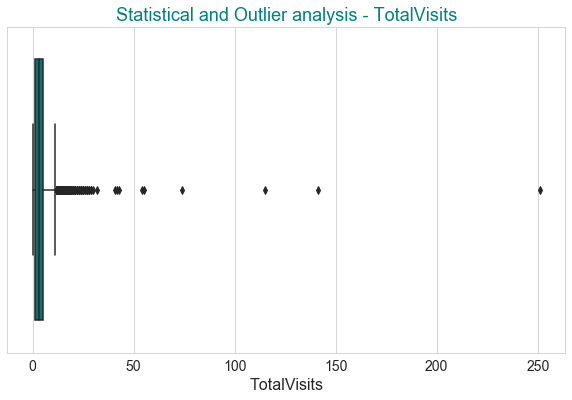

In [64]:
check_contin("TotalVisits")

In [65]:
# Imputing the null values with the median and capping outliers

leads['TotalVisits']=leads['TotalVisits'].fillna(leads['TotalVisits'].median())



In [66]:
#dropping outliers above the 99th percent value

q2T=leads['TotalVisits'].quantile(0.99)

leads =leads[leads['TotalVisits']<=q2T]

Statistical Description of TotalVisits: 
count   9157.0000
mean       3.2039
std        2.9678
min        0.0000
25%        1.0000
50%        3.0000
75%        5.0000
max       17.0000
Name: TotalVisits, dtype: float64


total number of nan value in TotalVisits column:  0




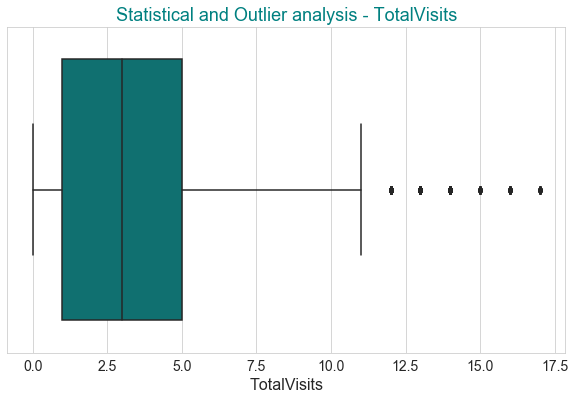

In [67]:
check_contin("TotalVisits")

#no null values and higher outliers capped.

Statistical Description of Total Time Spent on Website: 
count   9157.0000
mean     486.1890
std      547.6959
min        0.0000
25%       10.0000
50%      247.0000
75%      933.0000
max     2272.0000
Name: Total Time Spent on Website, dtype: float64


total number of nan value in Total Time Spent on Website column:  0




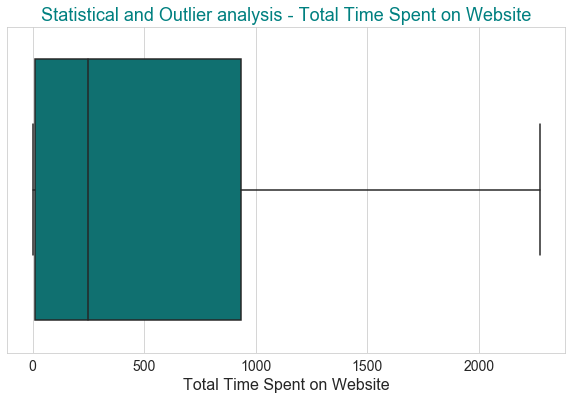

In [68]:
check_contin("Total Time Spent on Website")

#no null values and no outliers

Statistical Description of Page Views Per Visit: 
count   9020.0000
mean       2.3373
std        2.0624
min        0.0000
25%        1.0000
50%        2.0000
75%        3.0000
max       16.0000
Name: Page Views Per Visit, dtype: float64


total number of nan value in Page Views Per Visit column:  137




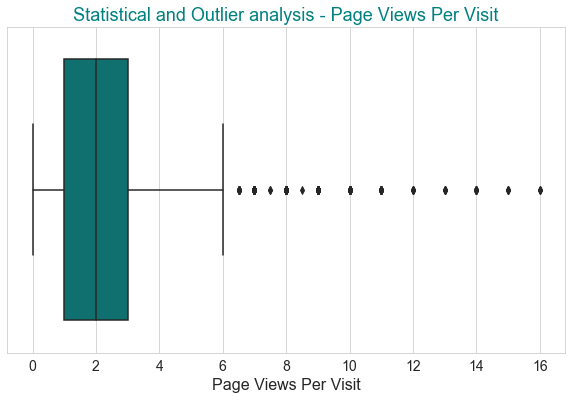

In [69]:
check_contin("Page Views Per Visit")

In [70]:
# Imputing the null values with the median and removing higher outliers

leads['Page Views Per Visit']=leads['Page Views Per Visit'].fillna(leads['Page Views Per Visit'].median())


In [71]:
#removing outliers above the 99th percent value

q2P=leads['Page Views Per Visit'].quantile(0.99)

leads =leads[leads['Page Views Per Visit']<=q2P]

Statistical Description of Page Views Per Visit: 
count   9090.0000
mean       2.2628
std        1.8812
min        0.0000
25%        1.0000
50%        2.0000
75%        3.0000
max        9.0000
Name: Page Views Per Visit, dtype: float64


total number of nan value in Page Views Per Visit column:  0




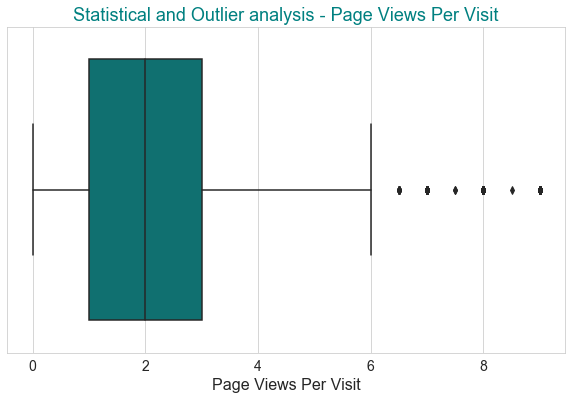

In [72]:
#chceking column again

check_contin("Page Views Per Visit")

#null values removed and higher outliers capped.

#### ANALYSING TARGET VARIABLE

0    5595
1    3495
Name: Converted, dtype: int64


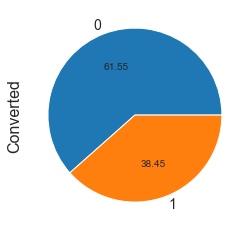

In [73]:
print(leads.Converted.value_counts())

leads.Converted.value_counts().plot.pie(autopct='%.2f')
plt.show()

***Inference:<br>***
- 38.45 percent of the total dataset is converted(Positive leads)
- 61.55 percent of data were negative leads.

In [74]:
#CHECKING THE PERCENTAGE OF ROWS RETAINED AFTER DATA CLEANING

bal_rows = round(100*(len(leads)/9240),2)

bal_rows


98.38

In [75]:
leads.shape

(9090, 9)

***Inference:<br>***
- 98.38 % data still available

### EDA ANALYSIS

#### UNIVARIATE - CATEGORICAL COLUMNS

In [76]:
#Defining a funtction to run EDA analysis on all categorical columns

def uni_cat(col):
    
    print("\033[1mTotal number of nan value in "+col+" column: \033[0m",leads[col].isnull().sum())
    print("\n")
    
    w = leads[col].nunique() #to get the width for plot
    
    if w<5:
        plt.figure(figsize=(5,6))
    else:
        plt.figure(figsize=(w,6))
        
    sns.countplot(x = col, data = leads, palette='husl', saturation = 1)
    plt.title("Analysis on "+col, weight = 'bold')
    plt.xticks(rotation=90)
    plt.show()

Total number of nan value in Lead Origin column:  0




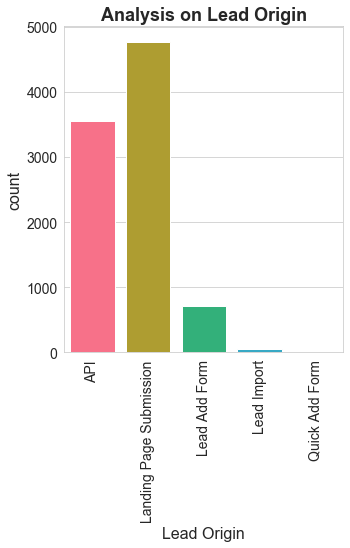

In [77]:
uni_cat('Lead Origin')

Total number of nan value in Lead Source column:  0




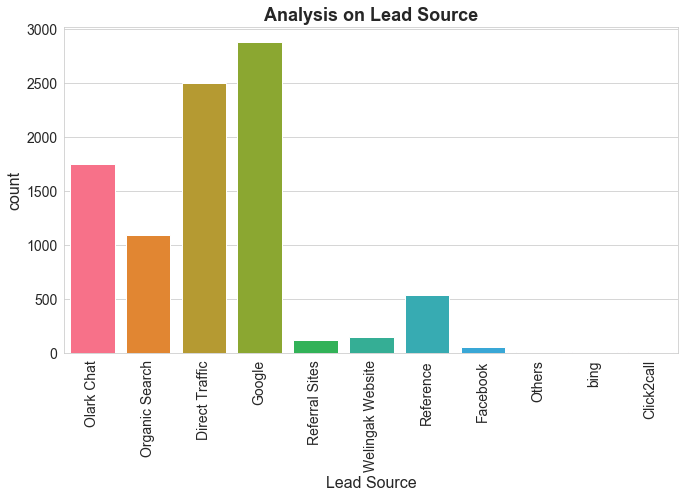

In [78]:
uni_cat("Lead Source")

Total number of nan value in Specialization column:  0




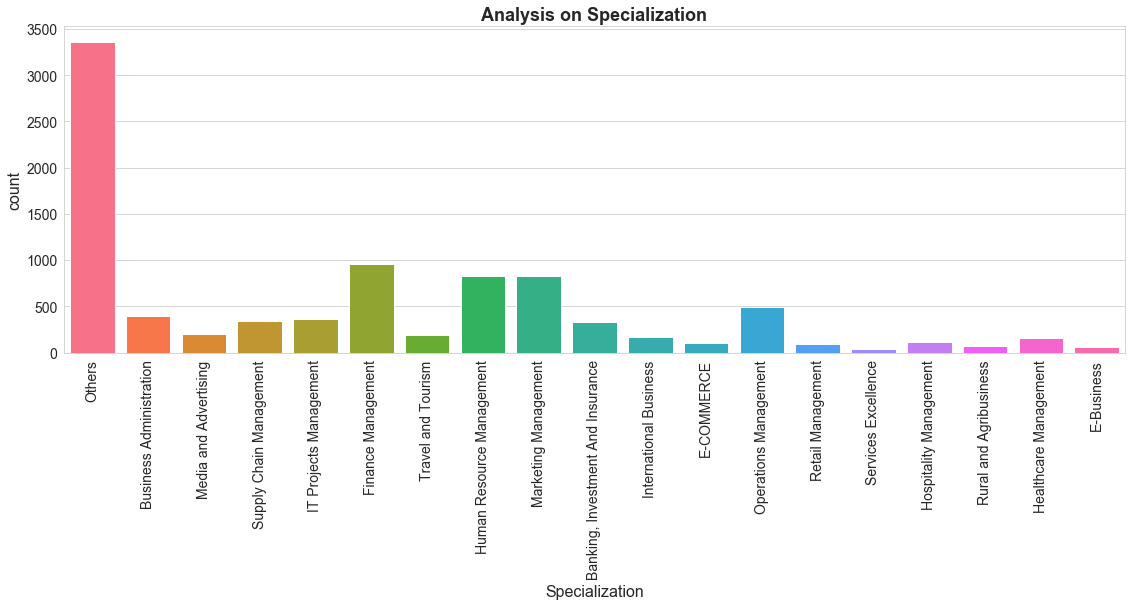

In [79]:
uni_cat('Specialization')

Total number of nan value in What is your current occupation column:  0




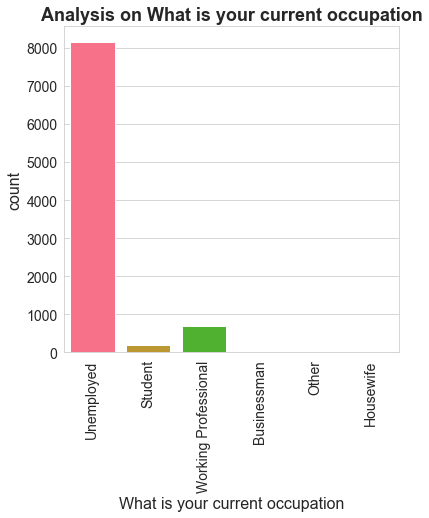

In [80]:
uni_cat("What is your current occupation")

Total number of nan value in A free copy of Mastering The Interview column:  0




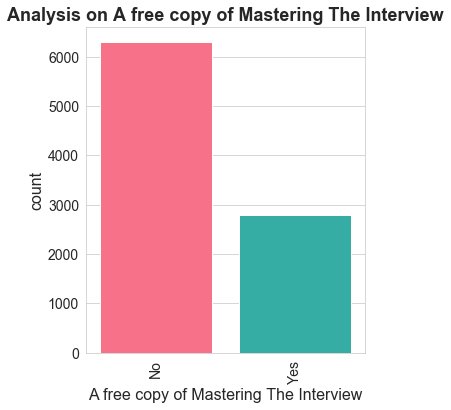

In [81]:
uni_cat('A free copy of Mastering The Interview')

#### UNIVARIATE - NUMERICAL COLUMNS

In [82]:
#defining a function

def uni_cont(col):
    
    #**** printing statistical info along with distribution plot for ease of analysing****

    print("\033[1mStatistical information of "+col+"\033[0m")
    print(leads[col].describe())
    
    plt.figure(figsize=(9,5))
    
    sns.distplot(leads[col], color='forestgreen')
    plt.title("Distribution of "+col+" column", color = 'crimson')
    
    plt.show()
    

Statistical information of TotalVisits
count   9090.0000
mean       3.1409
std        2.8819
min        0.0000
25%        1.0000
50%        3.0000
75%        4.0000
max       17.0000
Name: TotalVisits, dtype: float64


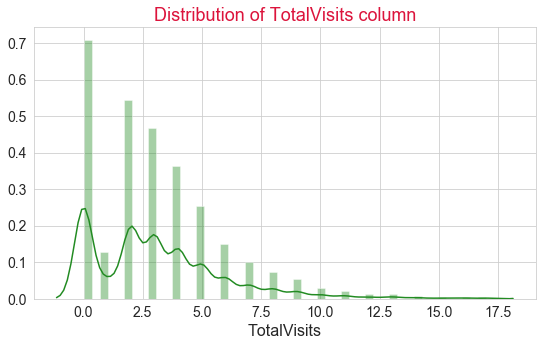

In [83]:
uni_cont('TotalVisits')

Statistical information of Total Time Spent on Website
count   9090.0000
mean     484.2438
std      547.2440
min        0.0000
25%        9.0000
50%      246.0000
75%      930.0000
max     2272.0000
Name: Total Time Spent on Website, dtype: float64


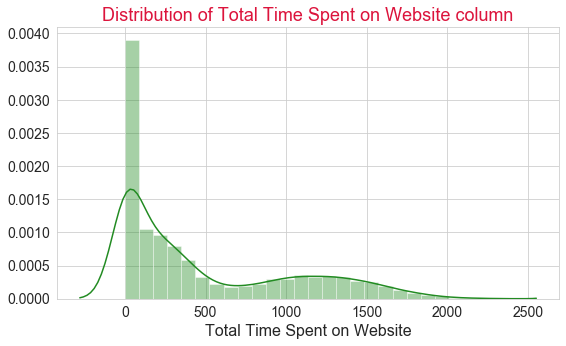

In [84]:
uni_cont('Total Time Spent on Website')

Statistical information of Page Views Per Visit
count   9090.0000
mean       2.2628
std        1.8812
min        0.0000
25%        1.0000
50%        2.0000
75%        3.0000
max        9.0000
Name: Page Views Per Visit, dtype: float64


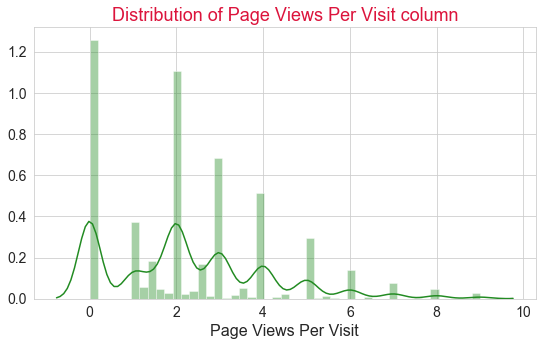

In [85]:
uni_cont('Page Views Per Visit')

#### BIVARIATE - CATEGORICAL w.r.t TARGET VARIABLE

In [86]:
#defining a function

def biv_cate(col):
    
    w = leads[col].nunique() #to get the width for plot
    
    if w<5:
        plt.figure(figsize=(5,6))
    else:
        plt.figure(figsize=(w,6))
    
    print("\n")
    
    sns.countplot(x = col, hue = 'Converted', data = leads, palette = ['grey','crimson'], saturation = 0.75)
    plt.title("Analysis on "+col+" w.r.t Target Variable - Converted", weight = 'bold')
    plt.xticks(rotation=90)
    plt.show()

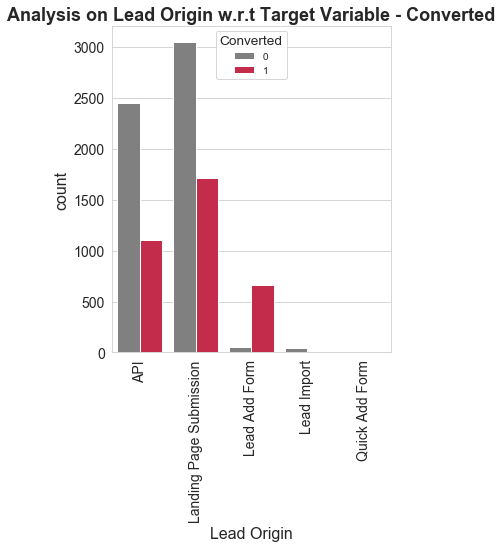

In [87]:
biv_cate("Lead Origin")

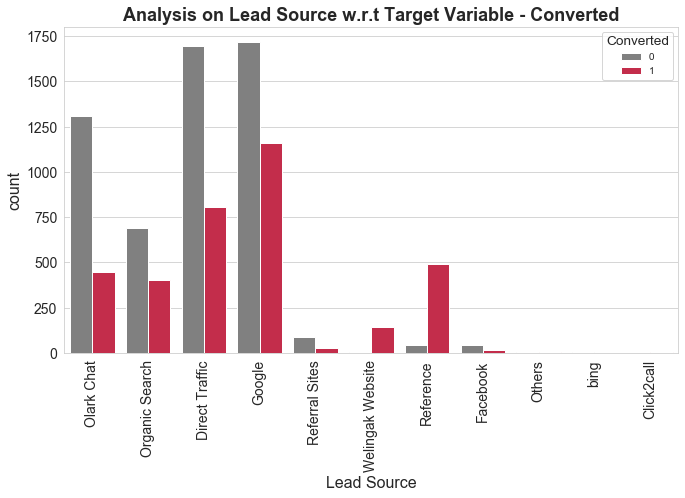

In [88]:
biv_cate("Lead Source")

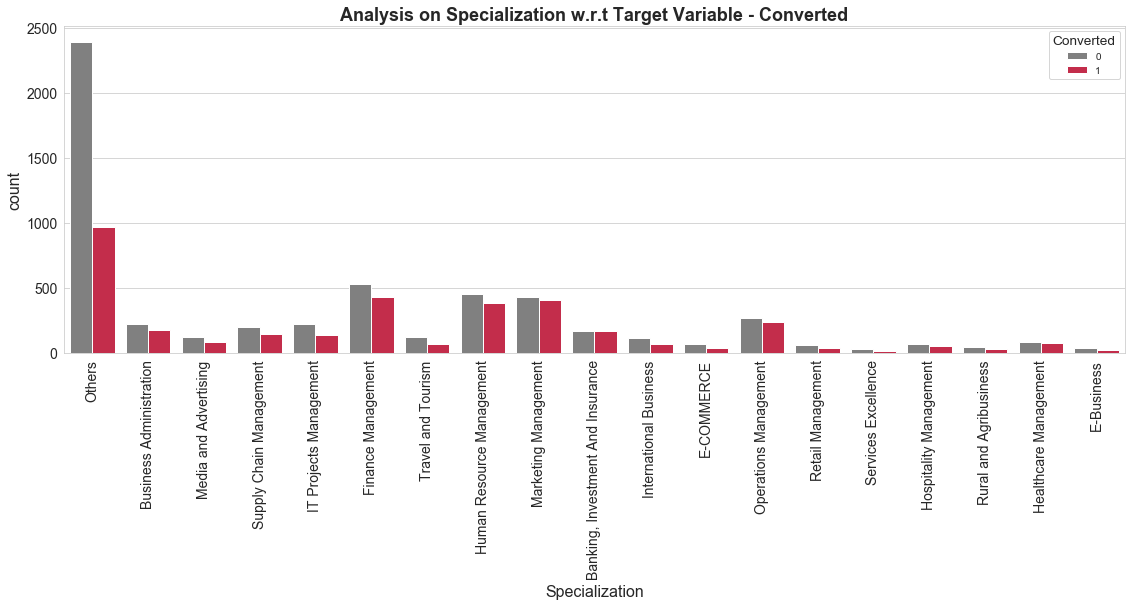

In [89]:
biv_cate('Specialization')

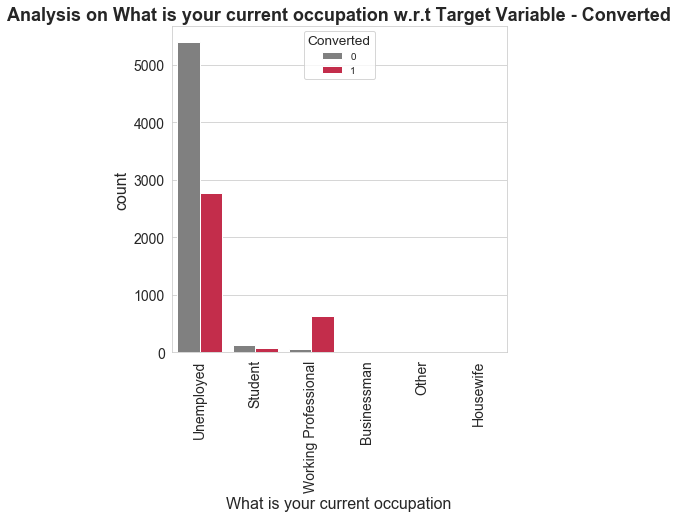

In [90]:
biv_cate("What is your current occupation")

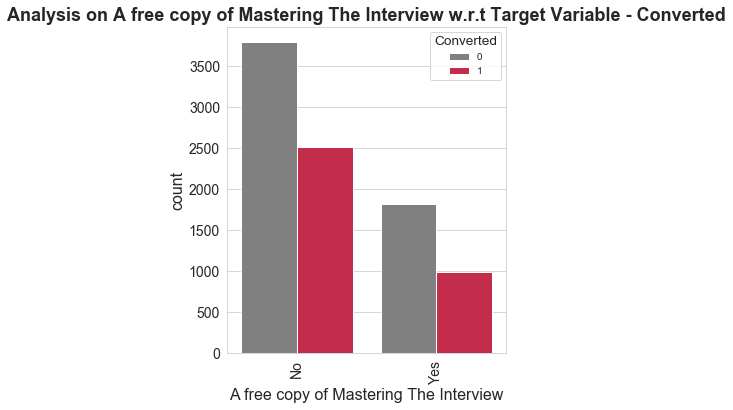

In [91]:
biv_cate('A free copy of Mastering The Interview')

#### BIVARIATE - CONTINOUS TO CONTINOUS

In [92]:
#defining a function

def biv_cont(x,y):
    
    plt.figure(figsize=(8,5))
    
    sns.scatterplot(x = leads[x], y = leads[y], color='crimson')
    plt.title("Distribution of "+x+" w.r.t "+y, weight = 'bold')
    
    plt.show()
    

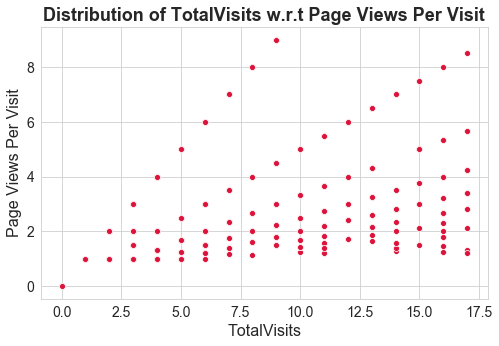

In [93]:
biv_cont('TotalVisits','Page Views Per Visit')

#there is a positive correlation

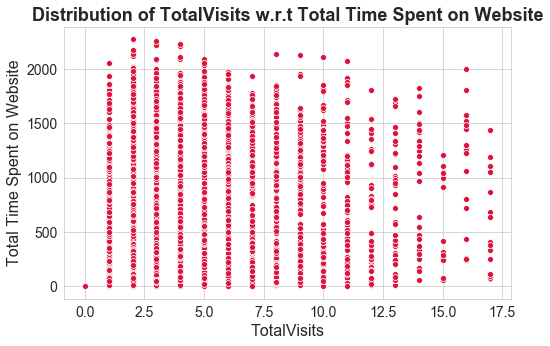

In [94]:
biv_cont('TotalVisits','Total Time Spent on Website')

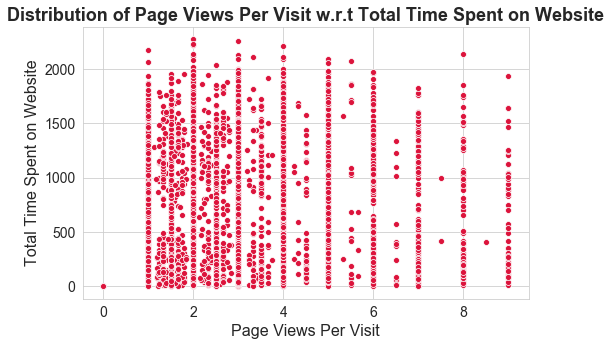

In [95]:
biv_cont('Page Views Per Visit','Total Time Spent on Website')

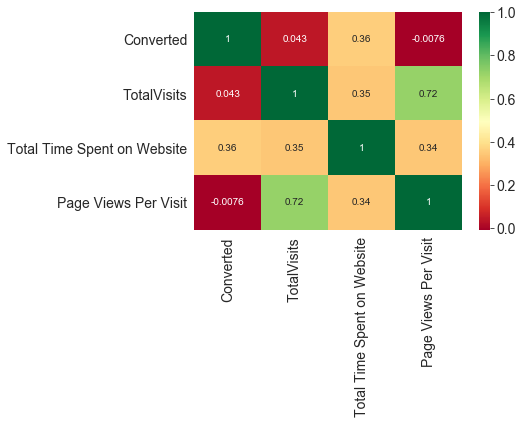

In [96]:
#heatmap

sns.heatmap(leads.corr(), annot = True, cmap = 'RdYlGn')
plt.show()

#### DUMMY VARIABLE CREATION FOR ALL CATEGORICAL VARIABLE

In [97]:
#map the binary variable

leads['A free copy of Mastering The Interview'] = leads['A free copy of Mastering The Interview'].map({"Yes": 1, "No": 0})

In [98]:
leads.head()

Lead Origin     Lead Source  Converted  TotalVisits  \
0                      API      Olark Chat          0       0.0000   
1                      API  Organic Search          0       5.0000   
2  Landing Page Submission  Direct Traffic          1       2.0000   
3  Landing Page Submission  Direct Traffic          0       1.0000   
4  Landing Page Submission          Google          1       2.0000   

   Total Time Spent on Website  Page Views Per Visit           Specialization  \
0                            0                0.0000                   Others   
1                          674                2.5000                   Others   
2                         1532                2.0000  Business Administration   
3                          305                1.0000    Media and Advertising   
4                         1428                1.0000                   Others   

  What is your current occupation  A free copy of Mastering The Interview  
0                      Unemployed                                       0  
1                      Unemployed                                       0  
2                         Student                                       1  
3                      Unemployed                                       0  
4                      Unemployed                                       0

In [99]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

cate_dummy = pd.get_dummies(leads[['Lead Origin','Lead Source','What is your current occupation','Specialization']], 
                            drop_first=True)

# Adding the results to the master dataframe

leads = pd.concat([leads, cate_dummy], axis=1)

In [100]:
cate_dummy.head()

Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
0                        0                           0   
1                        0                           0   
2                        0                           0   
3                        0                           0   
4                        0                           0   

   Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
0                           0                     0                   0   
1                           0                     0                   0   
2                           1                     0                   0   
3                           1                     0                   0   
4                           0                     0                   1   

   Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
0                       1                           0                   0   
1                       0                           1                   0   
2                       0                           0                   0   
3                       0                           0                   0   
4                       0                           0                   0   

   Lead Source_Reference  Lead Source_Referral Sites  \
0                      0                           0   
1                      0                           0   
2                      0                           0   
3                      0                           0   
4                      0                           0   

   Lead Source_Welingak Website  Lead Source_bing  \
0                             0                 0   
1                             0                 0   
2                             0                 0   
3                             0                 0   
4                             0                 0   

   What is your current occupation_Housewife  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   What is your current occupation_Other  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   What is your current occupation_Student  \
0                                        0   
1                                        0   
2                                        1   
3                                        0   
4                                        0   

   What is your current occupation_Unemployed  \
0                                           1   
1                                           1   
2                                           0   
3                                           1   
4                                           1   

   What is your current occupation_Working Professional  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   Specialization_Business Administration  Specialization_E-Business  \
0                                       0                          0   
1                                       0   

In [101]:
leads.head()

Lead Origin     Lead Source  Converted  TotalVisits  \
0                      API      Olark Chat          0       0.0000   
1                      API  Organic Search          0       5.0000   
2  Landing Page Submission  Direct Traffic          1       2.0000   
3  Landing Page Submission  Direct Traffic          0       1.0000   
4  Landing Page Submission          Google          1       2.0000   

   Total Time Spent on Website  Page Views Per Visit           Specialization  \
0                            0                0.0000                   Others   
1                          674                2.5000                   Others   
2                         1532                2.0000  Business Administration   
3                          305                1.0000    Media and Advertising   
4                         1428                1.0000                   Others   

  What is your current occupation  A free copy of Mastering The Interview  \
0                      Unemployed                                       0   
1                      Unemployed                                       0   
2                         Student                                       1   
3                      Unemployed                                       0   
4                      Unemployed                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
0                        0                           0   
1                        0                           0   
2                        0                           0   
3                        0                           0   
4                        0                           0   

   Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
0                           0                     0                   0   
1                           0                     0                   0   
2                           1                     0                   0   
3                           1                     0                   0   
4                           0                     0                   1   

   Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
0                       1                           0                   0   
1                       0                           1                   0   
2                       0                           0                   0   
3                       0                           0                   0   
4                       0                           0                   0   

   Lead Source_Reference  Lead Source_Referral Sites  \
0                      0                           0   
1                      0                           0   
2                      0                           0   
3                      0                           0   
4                      0                           0   

   Lead Source_Welingak Website  Lead Source_bing  \
0                             0                 0   
1                             0                 0   
2                             0                 0   
3                             0                 0   
4                             0                 0   

   What is your current occupation_Housewife  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   What is your curre

In [102]:
leads.shape

#now we have a total of 46 columns

(9090, 46)

In [103]:
#since dummies are created for categorical column, original variables can be dropped

leads = leads.drop(['Lead Origin','Lead Source','What is your current occupation','Specialization'], axis=1)

In [104]:
# check the shape

leads.head()

Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0       0.0000                            0                0.0000   
1          0       5.0000                          674                2.5000   
2          1       2.0000                         1532                2.0000   
3          0       1.0000                          305                1.0000   
4          1       2.0000                         1428                1.0000   

   A free copy of Mastering The Interview  \
0                                       0   
1                                       0   
2                                       1   
3                                       0   
4                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
0                        0                           0   
1                        0                           0   
2                        0                           0   
3                        0                           0   
4                        0                           0   

   Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
0                           0                     0                   0   
1                           0                     0                   0   
2                           1                     0                   0   
3                           1                     0                   0   
4                           0                     0                   1   

   Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
0                       1                           0                   0   
1                       0                           1                   0   
2                       0                           0                   0   
3                       0                           0                   0   
4                       0                           0                   0   

   Lead Source_Reference  Lead Source_Referral Sites  \
0                      0                           0   
1                      0                           0   
2                      0                           0   
3                      0                           0   
4                      0                           0   

   Lead Source_Welingak Website  Lead Source_bing  \
0                             0                 0   
1                             0                 0   
2                             0                 0   
3                             0                 0   
4                             0                 0   

   What is your current occupation_Housewife  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   What is your current occupation_Other  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   What is your current occupation_Student  \
0                                        0   
1                                        0   
2                                        1   
3                                        0   
4                                        0   

   What is your current occupation_Unemployed  \
0                                    

In [105]:
leads.shape

(9090, 42)

***Inferenece:<br>***
- 42 columns left

### Train Test Split

In [106]:
#Importing required libraries

from sklearn.model_selection import train_test_split


In [107]:
# Putting feature variable to X

X = leads.drop(['Converted'], axis=1)

X.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0       0.0000                            0                0.0000   
1       5.0000                          674                2.5000   
2       2.0000                         1532                2.0000   
3       1.0000                          305                1.0000   
4       2.0000                         1428                1.0000   

   A free copy of Mastering The Interview  \
0                                       0   
1                                       0   
2                                       1   
3                                       0   
4                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
0                        0                           0   
1                        0                           0   
2                        0                           0   
3                        0                           0   
4                        0                           0   

   Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
0                           0                     0                   0   
1                           0                     0                   0   
2                           1                     0                   0   
3                           1                     0                   0   
4                           0                     0                   1   

   Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
0                       1                           0                   0   
1                       0                           1                   0   
2                       0                           0                   0   
3                       0                           0                   0   
4                       0                           0                   0   

   Lead Source_Reference  Lead Source_Referral Sites  \
0                      0                           0   
1                      0                           0   
2                      0                           0   
3                      0                           0   
4                      0                           0   

   Lead Source_Welingak Website  Lead Source_bing  \
0                             0                 0   
1                             0                 0   
2                             0                 0   
3                             0                 0   
4                             0                 0   

   What is your current occupation_Housewife  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   What is your current occupation_Other  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   What is your current occupation_Student  \
0                                        0   
1                                        0   
2                                        1   
3                                        0   
4                                        0   

   What is your current occupation_Unemployed  \
0                                           1   
1                                           1   
2    

In [108]:
# Putting target variable to y

y = leads['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [109]:
# Splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

### Feature scaling

In [110]:
#importing required libraries

from sklearn.preprocessing import MinMaxScaler

In [111]:
scaler = MinMaxScaler()

X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits',
                                                                'Total Time Spent on Website','Page Views Per Visit']])

X_train.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
302        0.4118                       0.1100                0.2589   
6087       0.0000                       0.0000                0.0000   
1033       0.2941                       0.2069                0.5556   
7656       0.3529                       0.1549                0.6667   
3241       0.2353                       0.4283                0.1478   

      A free copy of Mastering The Interview  \
302                                        0   
6087                                       0   
1033                                       0   
7656                                       1   
3241                                       1   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
302                                     0                          0   
6087                                    0                          0   
1033                                    0                          0   
7656                                    1                          0   
3241                                    1                          0   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
302                         0                           0   
6087                        0                           0   
1033                        0                           0   
7656                        0                           0   
3241                        0                           0   

      Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
302                            0                     0                   0   
6087                           0                     0                   0   
1033                           0                     0                   1   
7656                           1                     0                   0   
3241                           1                     0                   0   

      Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
302                        0                           0                   0   
6087                       1                           0                   0   
1033                       0                           0                   0   
7656                       0                           0                   0   
3241                       0                           0                   0   

      Lead Source_Reference  Lead Source_Referral Sites  \
302                       0                           1   
6087                      0                           0   
1033                      0                           0   
7656                      0                           0   
3241                      0                           0   

      Lead Source_Welingak Website  Lead Source_bing  \
302                              0                 0   
6087                             0                 0   
1033                             0                 0   
7656                             0                 0   
3241                             0                 0   

      What is your current occupation_Housewife  \
302                                           0   
6087                                          0   
1033                                          0   
7656                                          0   
3241                                          0   

      What is your current occupation_Other  \
302                                       0   
6087                                      0   
1033                                      0   
7656                                      0   
3241                                      0   

      What is your current occupation_Student  \
302                                         0   
6087                                        0   
1033                                        0   
7656                                        0   
3241   

In [112]:
### Checking the Conversion Rate

conversion = (sum(leads['Converted'])/len(leads['Converted'].index))*100

conversion

38.448844884488445

***Inference:<br>***
- The conversion rate is ***38.45%***.

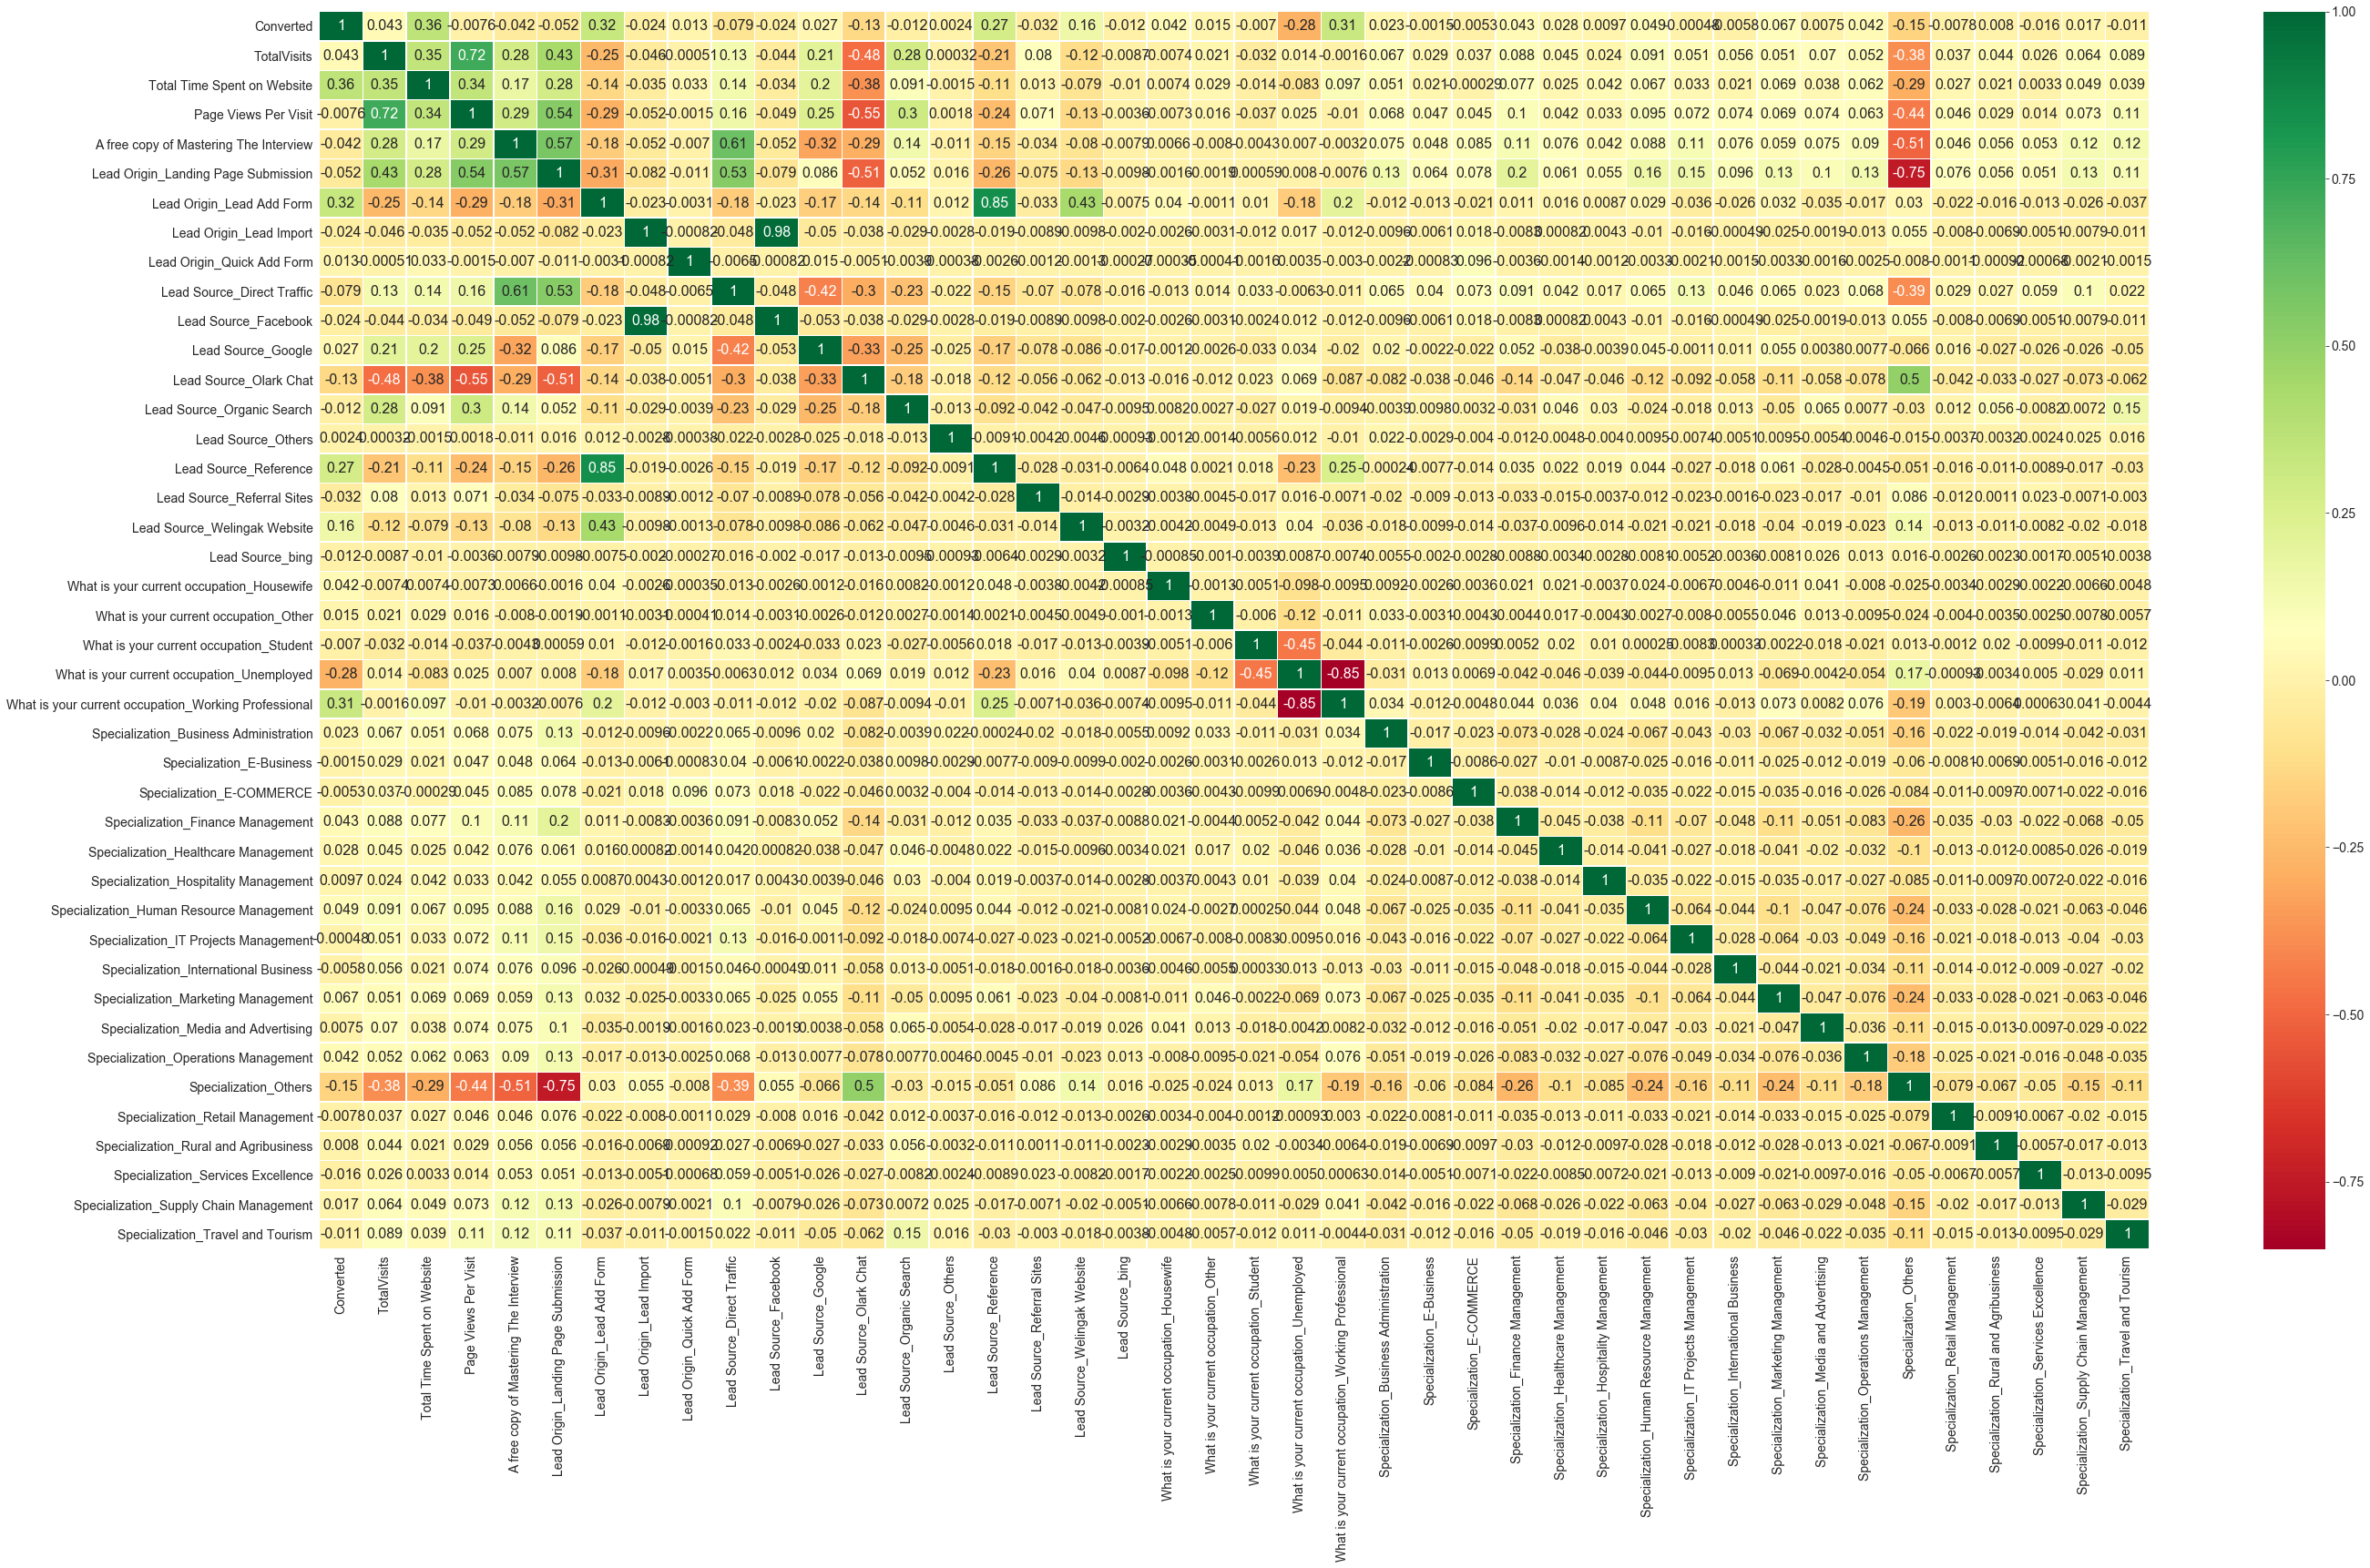

In [113]:
# Let's see the correlation matrix 

plt.figure(figsize = (45,25))        # Size of the figure

res = leads.corr()

sns.heatmap(res, annot = True, cmap="RdYlGn", linewidth=0.5, annot_kws={"size":16})

plt.show()

In [114]:
#top 10 correlated variables

top10 = res.unstack().sort_values(ascending=False).drop_duplicates()[1:11] 

top10

Lead Source_Facebook                    Lead Origin_Lead Import               0.9817
Lead Origin_Lead Add Form               Lead Source_Reference                 0.8529
Page Views Per Visit                    TotalVisits                           0.7211
A free copy of Mastering The Interview  Lead Source_Direct Traffic            0.6095
                                        Lead Origin_Landing Page Submission   0.5684
Page Views Per Visit                    Lead Origin_Landing Page Submission   0.5360
Lead Source_Direct Traffic              Lead Origin_Landing Page Submission   0.5343
Lead Source_Olark Chat                  Specialization_Others                 0.4997
TotalVisits                             Lead Origin_Landing Page Submission   0.4314
Lead Source_Welingak Website            Lead Origin_Lead Add Form             0.4305
dtype: float64

In [115]:
#dropping one of the highly correlated variables from train and test

X_test = X_test.drop(['Lead Origin_Lead Import'], axis = 1)

X_train = X_train.drop(['Lead Origin_Lead Import'], axis = 1)

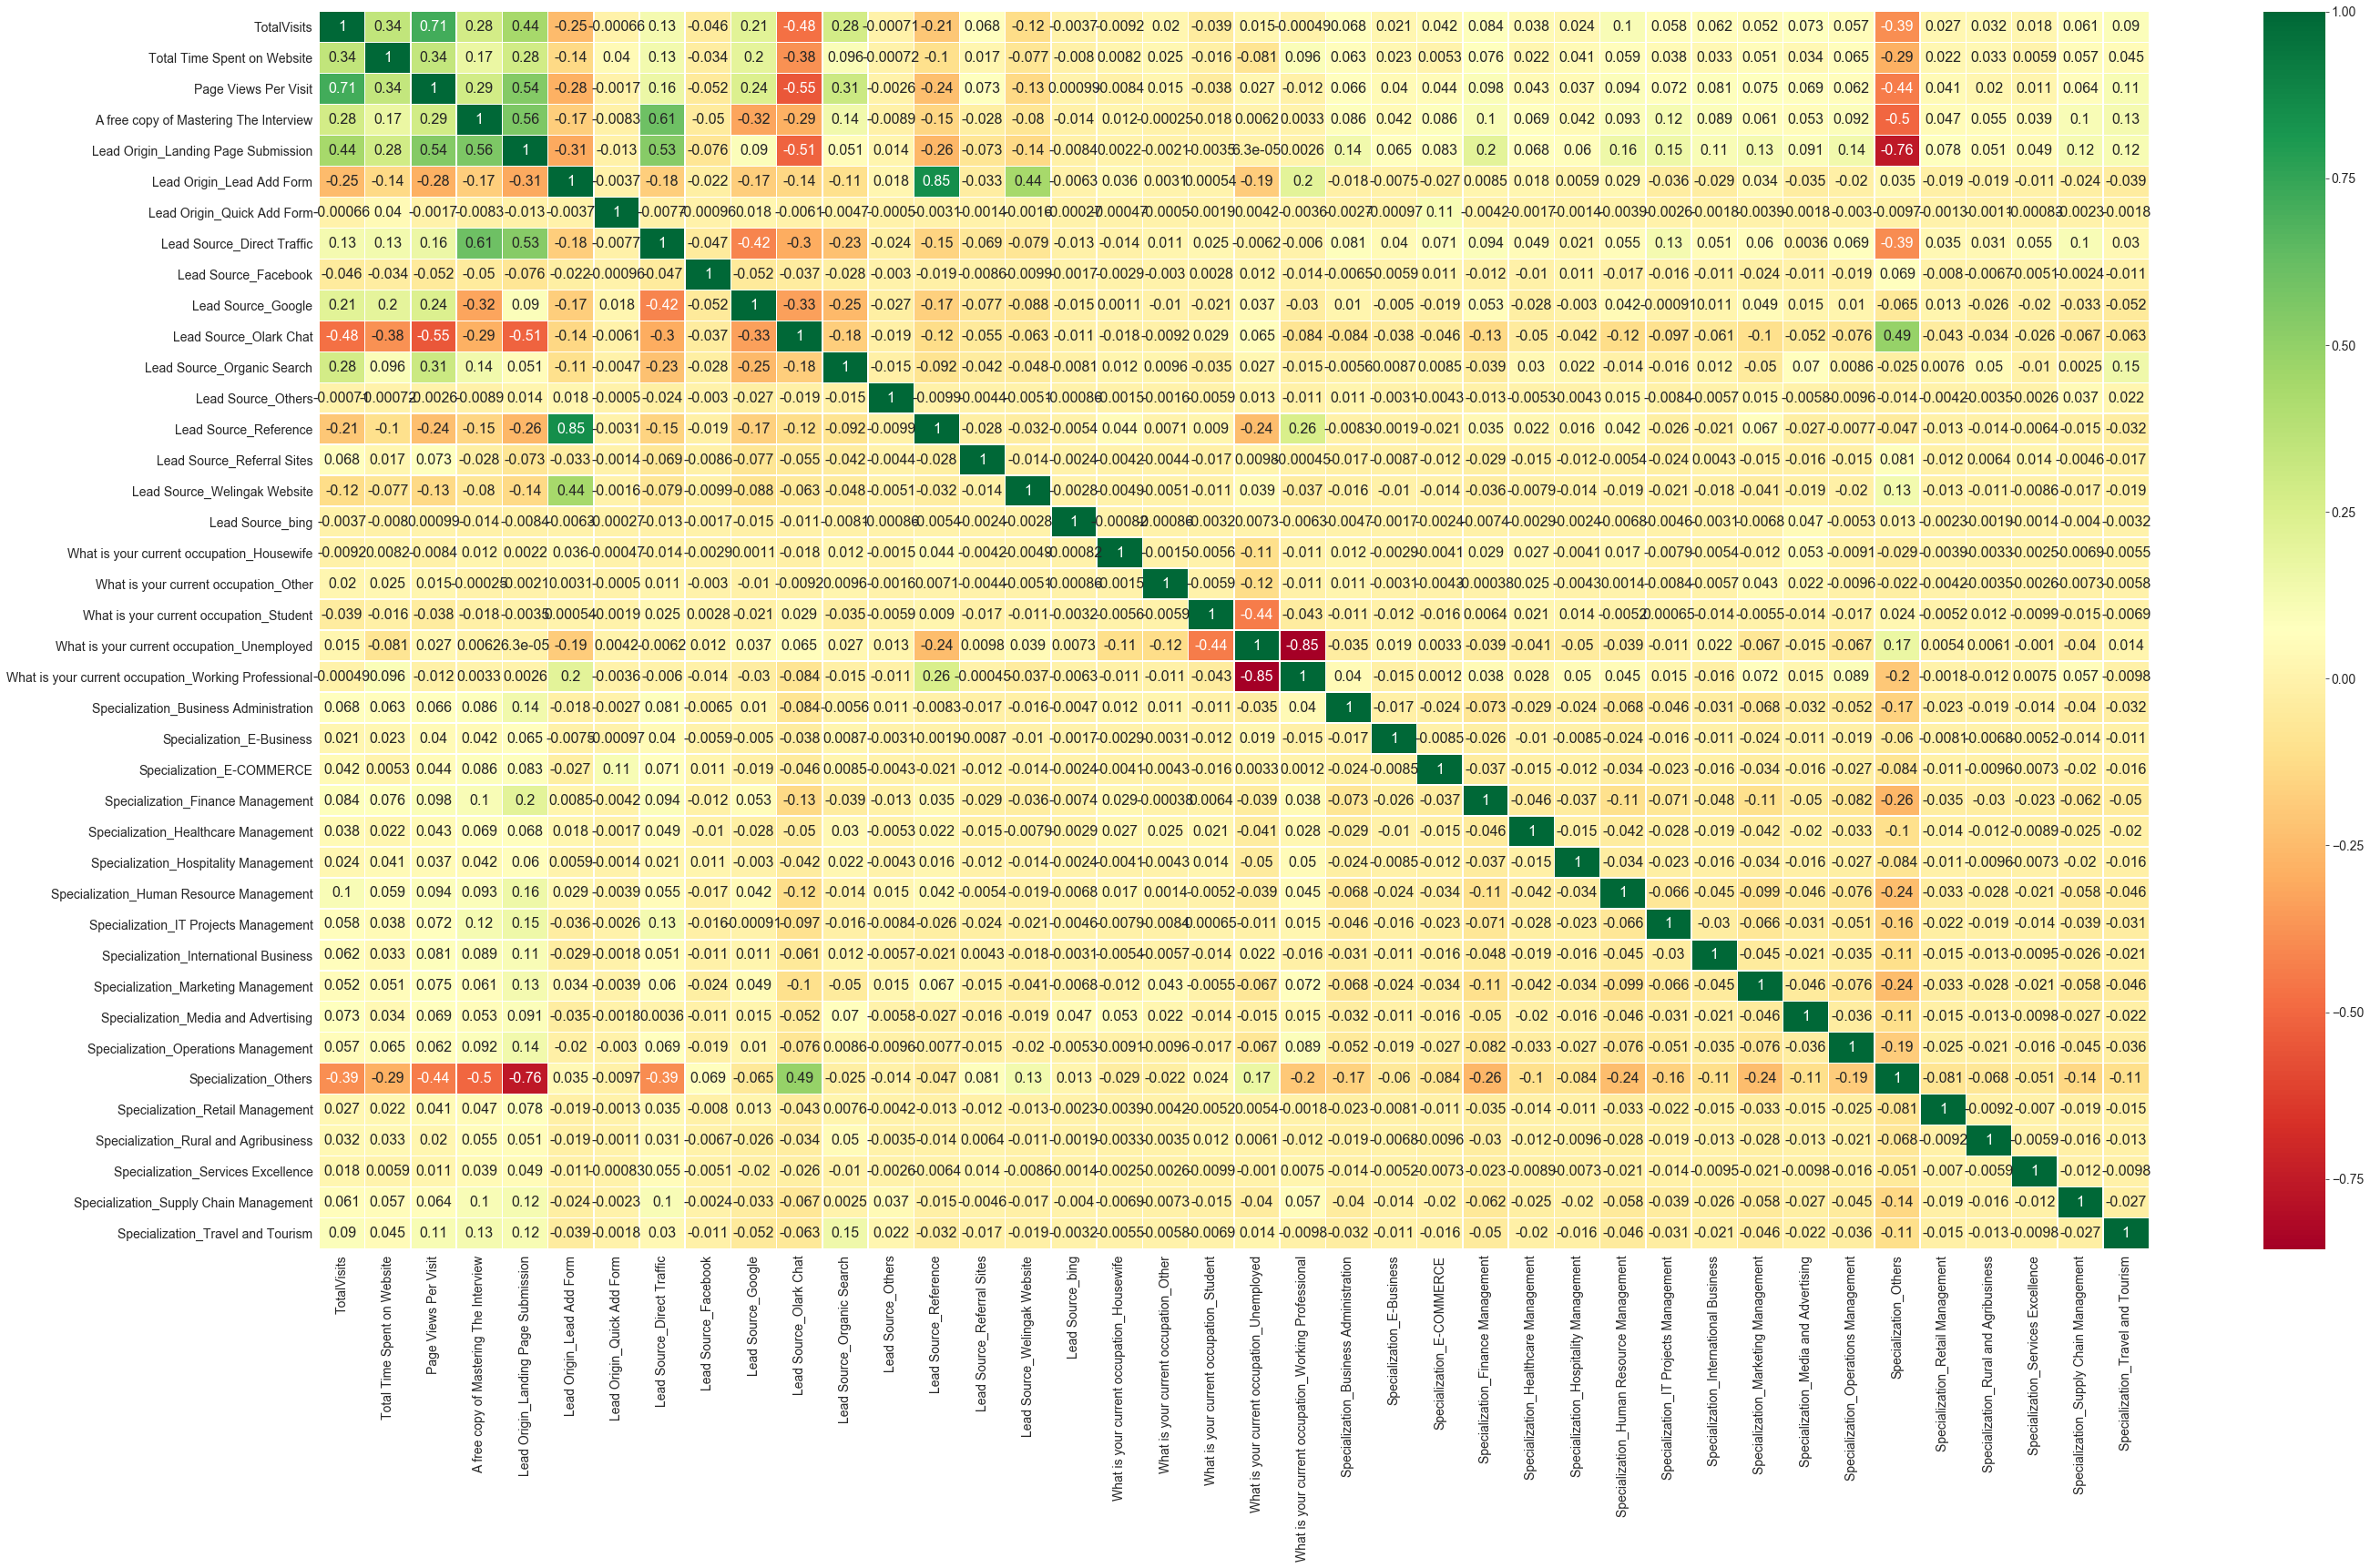

In [116]:
# Let's see the correlation matrix again for train data after dropping the highly correalted variables.

plt.figure(figsize = (45,25))        # Size of the figure

res = X_train.corr()

sns.heatmap(res, annot = True, cmap="RdYlGn", linewidth=0.5, annot_kws={"size":16})

plt.show()

### Model Building

In [117]:
#importing required libraries

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [118]:
# Logistic regression model

logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())

logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6322
Model Family:                Binomial   Df Model:                           40
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2959.9
Date:                Mon, 07 Dec 2020   Deviance:                       5919.9
Time:                        20:15:19   Pearson chi2:                 7.96e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   16.9348    3.3e+04      0.001      1.000   -6.47e+04    6.47e+04
TotalVisits                                              1.0198      0.267      3.824      0.000       0.497       1.543
Total Time Spent on Website                              4.4553      0.158     28.264      0.000       4.146       4.764
Page Views Per Visit                                    -0.2305      0.250     -0.922      0.357      -0.721       0.260
A free copy of Mastering The Interview                  -0.1519      0.102     -1.497      0.135      -0.351       0.047
Lead Origin_Landing Page Submission                     -0.6891      0.129     -5.323      0.000      -0.943      -0.435
Lead Origin_Lead Add Form                                4.1663      0.634      6.576      0.000       2.925       5.408
Lead Origin_Quick Add Form                              19.0326   4.82e+04      0.000      1.000   -9.44e+04    9.45e+04
Lead Source_Direct Traffic                             -17.6973    3.3e+04     -0.001      1.000   -6.47e+04    6.47e+04
Lead Source_Facebook                                   -17.7961    3.3e+04     -0.001      1.000   -6.47e+04    6.47e+04
Lead Source_Google                                     -17.3977    3.3e+04     -0.001      1.000   -6.47e+04    6.47e+04
Lead Source_Olark Chat                                 -16.5388    3.3e+04     -0.001      1.000   -6.47e+04    6.47e+04
Lead Source_Organic Search                             -17.5307    3.3e+04     -0.001      1.000   -6.47e+04    6.47e+04
Lead Source_Others                                     -17.1560    3.3e+04     -0.001      1.000   -6.47e+04    6.47e+04
Lead Source_Reference                                  -18.1342    3.3e+04     -0.001      1.000   -6.47e+04    6.47e+04
Lead Source_Referral Sites                             -17.7033    3.3e+04     -0.001      1.000   -6.47e+04    6.47e+04
Lead Source_Welingak Website                           -14.7677    3.3e+04     -0.000      1.000   -6.47e+04    6.47e+04
Lead Source_bing                                       -16.5288    3.3e+04     -0.001      1.000   -6.47e+04    6.47e+04
What is your current occupation_Housewife               22.1386   1.35e+04      0.002      0.999   -2.64e+04    2.65e+04
What is your current occupation_Other                   -0.3905      1.347     -0.290      0.772      -3.030       2.249
What is your current occupation_Student                 -0.4886      1.141     -0.428      0.668      -2.725       1.748
What is your current occupation_Unemployed              -0.6263      1.121     -0.559      0.576      -2.823       1.570
What is your current occupation_Working Professional     2

In [119]:
logreg = LogisticRegression()

In [120]:
#selecting 15 variables with RFE

rfe = RFE(logreg, 15)             # running RFE with 15 variables as output

rfe = rfe.fit(X_train, y_train)

In [121]:
rfe.support_

array([ True,  True, False, False,  True,  True, False, False, False,
       False,  True, False, False, False, False,  True, False,  True,
        True,  True,  True,  True, False, False, False, False, False,
        True, False, False, False, False, False, False,  True,  True,
       False,  True, False, False])

In [122]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 12),
 ('A free copy of Mastering The Interview', False, 14),
 ('Lead Origin_Landing Page Submission', True, 1),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Quick Add Form', False, 20),
 ('Lead Source_Direct Traffic', False, 3),
 ('Lead Source_Facebook', False, 4),
 ('Lead Source_Google', False, 9),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 7),
 ('Lead Source_Others', False, 21),
 ('Lead Source_Reference', False, 8),
 ('Lead Source_Referral Sites', False, 6),
 ('Lead Source_Welingak Website', True, 1),
 ('Lead Source_bing', False, 11),
 ('What is your current occupation_Housewife', True, 1),
 ('What is your current occupation_Other', True, 1),
 ('What is your current occupation_Student', True, 1),
 ('What is your current occupation_Unemployed', True, 1),
 ('What is your current occupation_Working Professional', True, 1),
 ('Specialization_

In [123]:
rfe_cols = X_train.columns[rfe.support_]

rfe_cols

Index(['TotalVisits', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Source_Olark Chat', 'Lead Source_Welingak Website',
       'What is your current occupation_Housewife',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Specialization_Hospitality Management', 'Specialization_Others',
       'Specialization_Retail Management',
       'Specialization_Services Excellence'],
      dtype='object')

In [124]:
X_train.columns[~rfe.support_]

Index(['Page Views Per Visit', 'A free copy of Mastering The Interview',
       'Lead Origin_Quick Add Form', 'Lead Source_Direct Traffic',
       'Lead Source_Facebook', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Others',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Lead Source_bing', 'Specialization_Business Administration',
       'Specialization_E-Business', 'Specialization_E-COMMERCE',
       'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Human Resource Management',
       'Specialization_IT Projects Management',
       'Specialization_International Business',
       'Specialization_Marketing Management',
       'Specialization_Media and Advertising',
       'Specialization_Operations Management',
       'Specialization_Rural and Agribusiness',
       'Specialization_Supply Chain Management',
       'Specialization_Travel and Tourism'],
      dtype='object')

### Model 1: with columns selected using RFE

In [125]:
X_train_rfe = X_train[rfe_cols]

In [126]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [127]:
logm2 = sm.GLM(y_train, X_train_rfe, family = sm.families.Binomial())

res = logm2.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6347
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2977.1
Date:                Mon, 07 Dec 2020   Deviance:                       5954.2
Time:                        20:15:21   Pearson chi2:                 8.19e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.8044      1.088     -0.739      0.460      -2.937       1.328
TotalVisits                                              0.9318      0.229      4.077      0.000       0.484       1.380
Total Time Spent on Website                              4.4411      0.156     28.391      0.000       4.134       4.748
Lead Origin_Landing Page Submission                     -0.8465      0.121     -6.994      0.000      -1.084      -0.609
Lead Origin_Lead Add Form                                3.6299      0.210     17.276      0.000       3.218       4.042
Lead Source_Olark Chat                                   0.9618      0.121      7.975      0.000       0.725       1.198
Lead Source_Welingak Website                             3.2674      1.023      3.193      0.001       1.262       5.273
What is your current occupation_Housewife               22.0652   1.35e+04      0.002      0.999   -2.65e+04    2.66e+04
What is your current occupation_Other                   -0.4749      1.312     -0.362      0.717      -3.047       2.097
What is your current occupation_Student                 -0.5085      1.103     -0.461      0.645      -2.671       1.654
What is your current occupation_Unemployed              -0.6346      1.083     -0.586      0.558      -2.757       1.487
What is your current occupation_Working Professional     2.0716      1.097      1.889      0.059      -0.078       4.221
Specialization_Hospitality Management                   -0.8244      0.324     -2.545      0.011      -1.459      -0.189
Specialization_Others                                   -1.0567      0.117     -9.044      0.000      -1.286      -0.828
Specialization_Retail Management                        -0.3826      0.318     -1.203      0.229      -1.006       0.241
Specialization_Services Excellence                      -0.6696      0.517     -1.295      0.195      -1.683       0.344
========================================================================================================================
"""

In [128]:
#let us predict the values of y_train

y_train_pred = res.predict(X_train_rfe)

y_train_pred[:10]

302    0.1647
6087   0.1774
1033   0.2137
7656   0.2195
3241   0.4590
5738   0.1080
7366   0.1966
3680   0.1353
4170   0.4377
43     0.1712
dtype: float64

In [129]:
y_train_pred = y_train_pred.values.reshape(-1)

y_train_pred[:10]

array([0.16473722, 0.17742101, 0.21366266, 0.21950573, 0.45901488,
       0.10799877, 0.19657427, 0.13526336, 0.43774579, 0.17115379])

In [130]:
#creating a dataframe with conversion rate and predicted probability

y_train_pred_df = pd.DataFrame({"Converted": y_train.values, "Conv_Probability": y_train_pred})

y_train_pred_df.head()

Converted  Conv_Probability
0          0            0.1647
1          0            0.1774
2          0            0.2137
3          0            0.2195
4          1            0.4590

In [131]:
#creating a new colum 'Predicted' with values 1 and 0; resulting from a cut off of 0.5 from Conv_Probability

y_train_pred_df['Predicted'] = y_train_pred_df.Conv_Probability.map(lambda x: 1 if x > 0.5 else 0)

y_train_pred_df.head()

Converted  Conv_Probability  Predicted
0          0            0.1647          0
1          0            0.1774          0
2          0            0.2137          0
3          0            0.2195          0
4          1            0.4590          0

In [132]:
#importing required libraries

from sklearn import metrics

In [133]:
#confusion metrics

confusion = metrics.confusion_matrix(y_train_pred_df.Converted, y_train_pred_df.Predicted)

print(confusion)

[[3458  477]
 [ 916 1512]]


In [134]:
#checking overall accuracy

print(metrics.accuracy_score(y_train_pred_df.Converted, y_train_pred_df.Predicted))

0.7810781078107811


***LETS CHECK THE VIF***

In [135]:
#creating a dataframe to store the vif values

vif = pd.DataFrame()

vif['Features'] = X_train_rfe.columns

vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]

vif['VIF'] = round(vif['VIF'], 2) #rounding the values to two decimal places

vif = vif.sort_values(by='VIF', ascending = False)

vif

Features       VIF
0                                               const 1289.1000
10         What is your current occupation_Unemployed  117.3700
11  What is your current occupation_Working Profes...   91.5200
9             What is your current occupation_Student   28.0500
3                 Lead Origin_Landing Page Submission    3.5000
8               What is your current occupation_Other    3.0000
13                              Specialization_Others    3.0000
7           What is your current occupation_Housewife    2.8000
5                              Lead Source_Olark Chat    2.0100
4                           Lead Origin_Lead Add Form    1.9500
1                                         TotalVisits    1.5600
6                        Lead Source_Welingak Website    1.3100
2                         Total Time Spent on Website    1.2700
12              Specialization_Hospitality Management    1.0100
14                   Specialization_Retail Management    1.0100
15                 Specialization_Services Excellence    1.0000

***Inference:<br>***
- ***'What is your current occupation_Housewife'*** has high P value which indicates the insignificance of the variable,hence it has to be dropped and model has to be rebuilt.
- Accuracy for model 1 is 78 %

### Model 2

In [136]:
#'What is your current occupation_Housewife' has the highest P value

#dropping this column 

X_train_new = X_train_rfe.drop('What is your current occupation_Housewife', axis = 1)

In [137]:
#building model again

X_train_lm = sm.add_constant(X_train_new)

logm3 = sm.GLM(y_train, X_train_lm, family = sm.families.Binomial())

res = logm3.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6348
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2979.4
Date:                Mon, 07 Dec 2020   Deviance:                       5958.7
Time:                        20:15:22   Pearson chi2:                 8.19e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.6777      0.853      0.794      0.427      -0.995       2.350
TotalVisits                                              0.9149      0.229      4.004      0.000       0.467       1.363
Total Time Spent on Website                              4.4420      0.156     28.398      0.000       4.135       4.749
Lead Origin_Landing Page Submission                     -0.8410      0.121     -6.951      0.000      -1.078      -0.604
Lead Origin_Lead Add Form                                3.6297      0.210     17.276      0.000       3.218       4.042
Lead Source_Olark Chat                                   0.9617      0.121      7.974      0.000       0.725       1.198
Lead Source_Welingak Website                             3.2672      1.023      3.193      0.001       1.261       5.273
What is your current occupation_Other                   -1.9560      1.125     -1.739      0.082      -4.161       0.249
What is your current occupation_Student                 -1.9915      0.870     -2.288      0.022      -3.698      -0.285
What is your current occupation_Unemployed              -2.1168      0.844     -2.507      0.012      -3.772      -0.462
What is your current occupation_Working Professional     0.5886      0.862      0.683      0.495      -1.101       2.278
Specialization_Hospitality Management                   -0.8251      0.324     -2.547      0.011      -1.460      -0.190
Specialization_Others                                   -1.0560      0.117     -9.040      0.000      -1.285      -0.827
Specialization_Retail Management                        -0.3837      0.318     -1.207      0.228      -1.007       0.240
Specialization_Services Excellence                      -0.6705      0.517     -1.297      0.195      -1.684       0.343
========================================================================================================================
"""

In [138]:
#let us predict the values of y_train

y_train_pred = res.predict(X_train_lm)

y_train_pred[:10]

302    0.1639
6087   0.1775
1033   0.2130
7656   0.2194
3241   0.4595
5738   0.1083
7366   0.1965
3680   0.1355
4170   0.4382
43     0.1712
dtype: float64

In [139]:
y_train_pred = y_train_pred.values.reshape(-1)

y_train_pred[:10]

array([0.16387537, 0.1774891 , 0.21295792, 0.21942337, 0.45945231,
       0.10832293, 0.19652967, 0.13554546, 0.43817491, 0.17121889])

In [140]:
#creating a dataframe with conversion rate and predicted probability

y_train_pred_df = pd.DataFrame({"Converted": y_train.values, "Conv_Probability": y_train_pred})

y_train_pred_df.head()

Converted  Conv_Probability
0          0            0.1639
1          0            0.1775
2          0            0.2130
3          0            0.2194
4          1            0.4595

In [141]:
#creating a new colum 'Predicted' with values 1 and 0; resulting from a cut off of 0.5 from Conv_Probability

y_train_pred_df['Predicted'] = y_train_pred_df.Conv_Probability.map(lambda x: 1 if x > 0.5 else 0)

y_train_pred_df.head()

Converted  Conv_Probability  Predicted
0          0            0.1639          0
1          0            0.1775          0
2          0            0.2130          0
3          0            0.2194          0
4          1            0.4595          0

In [142]:
#confusion matrics

confusion = metrics.confusion_matrix(y_train_pred_df.Converted, y_train_pred_df.Predicted)

print(confusion)

[[3458  477]
 [ 915 1513]]


In [143]:
#checking overall accuracy

print(metrics.accuracy_score(y_train_pred_df.Converted, y_train_pred_df.Predicted))

0.7812352663837813


***Inference:<br>***
- Accuracy have not dropped. lets us check the vif again.

In [144]:
#creating a dataframe to store the vif values

vif = pd.DataFrame()

vif['Features'] = X_train_lm.columns

vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]

vif['VIF'] = round(vif['VIF'], 2) #rounding the values to two decimal places

vif = vif.sort_values(by='VIF', ascending = False)

vif

Features      VIF
0                                               const 469.3800
9          What is your current occupation_Unemployed  42.0900
10  What is your current occupation_Working Profes...  33.2500
8             What is your current occupation_Student  10.6700
3                 Lead Origin_Landing Page Submission   3.5000
12                              Specialization_Others   3.0000
5                              Lead Source_Olark Chat   2.0100
4                           Lead Origin_Lead Add Form   1.9500
7               What is your current occupation_Other   1.7100
1                                         TotalVisits   1.5600
6                        Lead Source_Welingak Website   1.3100
2                         Total Time Spent on Website   1.2700
11              Specialization_Hospitality Management   1.0100
13                   Specialization_Retail Management   1.0100
14                 Specialization_Services Excellence   1.0000


***Inference:<br>***
- ***'What is your current occupation_Working Professional'*** has high P value which indicates the variable is insignificant,hence it has to be dropped and model has to be rebuilt.
- Accuracy for model 2 is 78%

### Model 3

In [145]:

#'What is your current occupation_Working Professional' has the highest p value

#dropping this column 

X_train_new = X_train_lm.drop('What is your current occupation_Working Professional', axis = 1)

In [146]:
#building model again

X_train_lm = sm.add_constant(X_train_new)

logm4 = sm.GLM(y_train, X_train_lm, family = sm.families.Binomial())

res = logm4.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6349
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2979.6
Date:                Mon, 07 Dec 2020   Deviance:                       5959.2
Time:                        20:15:23   Pearson chi2:                 8.15e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          1.2450      0.215      5.802      0.000       0.824       1.666
TotalVisits                                    0.9130      0.229      3.994      0.000       0.465       1.361
Total Time Spent on Website                    4.4423      0.156     28.399      0.000       4.136       4.749
Lead Origin_Landing Page Submission           -0.8409      0.121     -6.948      0.000      -1.078      -0.604
Lead Origin_Lead Add Form                      3.6296      0.210     17.275      0.000       3.218       4.041
Lead Source_Olark Chat                         0.9623      0.121      7.980      0.000       0.726       1.199
Lead Source_Welingak Website                   3.2676      1.023      3.193      0.001       1.262       5.273
What is your current occupation_Other         -2.5230      0.764     -3.302      0.001      -4.021      -1.025
What is your current occupation_Student       -2.5586      0.275     -9.296      0.000      -3.098      -2.019
What is your current occupation_Unemployed    -2.6838      0.178    -15.107      0.000      -3.032      -2.336
Specialization_Hospitality Management         -0.8218      0.324     -2.540      0.011      -1.456      -0.188
Specialization_Others                         -1.0567      0.117     -9.044      0.000      -1.286      -0.828
Specialization_Retail Management              -0.3823      0.318     -1.203      0.229      -1.005       0.241
Specialization_Services Excellence            -0.6686      0.517     -1.294      0.196      -1.681       0.344
==============================================================================================================
"""

In [147]:
#let us predict the values of y_train

y_train_pred = res.predict(X_train_lm)

y_train_pred[:10]

302    0.1637
6087   0.1775
1033   0.2128
7656   0.2194
3241   0.4595
5738   0.1083
7366   0.1966
3680   0.1356
4170   0.4382
43     0.1712
dtype: float64

In [148]:
y_train_pred = y_train_pred.values.reshape(-1)

y_train_pred[:10]

array([0.16373073, 0.17753094, 0.21282451, 0.21938344, 0.45947261,
       0.10834054, 0.19655479, 0.13555503, 0.43819354, 0.17119957])

In [149]:
#creating a dataframe with conversion rate and predicted probability

y_train_pred_df = pd.DataFrame({"Converted": y_train.values, "Conv_Probability": y_train_pred})

y_train_pred_df.head()

Converted  Conv_Probability
0          0            0.1637
1          0            0.1775
2          0            0.2128
3          0            0.2194
4          1            0.4595

In [150]:
#creating a new colum 'Predicted' with values 1 and 0; resulting from a cut off of 0.5 from Conv_Probability

y_train_pred_df['Predicted'] = y_train_pred_df.Conv_Probability.map(lambda x: 1 if x > 0.5 else 0)

y_train_pred_df.head()

Converted  Conv_Probability  Predicted
0          0            0.1637          0
1          0            0.1775          0
2          0            0.2128          0
3          0            0.2194          0
4          1            0.4595          0

In [151]:
#confusion matrics

confusion = metrics.confusion_matrix(y_train_pred_df.Converted, y_train_pred_df.Predicted)

print(confusion)

[[3458  477]
 [ 915 1513]]


In [152]:
#checking overall accuracy

print(metrics.accuracy_score(y_train_pred_df.Converted, y_train_pred_df.Predicted))

0.7812352663837813


In [153]:
#creating a dataframe to store the vif values

vif = pd.DataFrame()

vif['Features'] = X_train_lm.columns

vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]

vif['VIF'] = round(vif['VIF'], 2) #rounding the values to two decimal places

vif = vif.sort_values(by='VIF', ascending = False)

vif

Features     VIF
0                                        const 28.2100
3          Lead Origin_Landing Page Submission  3.5000
11                       Specialization_Others  3.0000
5                       Lead Source_Olark Chat  2.0100
4                    Lead Origin_Lead Add Form  1.9500
1                                  TotalVisits  1.5600
9   What is your current occupation_Unemployed  1.4500
6                 Lead Source_Welingak Website  1.3100
8      What is your current occupation_Student  1.2900
2                  Total Time Spent on Website  1.2700
7        What is your current occupation_Other  1.0200
10       Specialization_Hospitality Management  1.0100
12            Specialization_Retail Management  1.0100
13          Specialization_Services Excellence  1.0000

***Inference:<br>***
- ***'Specialization_Retail Management'*** has high P value which indicates the variable is insignificant,hence it has to be dropped and model has to be rebuilt.
- Accuracy for model 3 is 78%

### Model 4

In [154]:
#'Specialization_Retail Management' has the highest p 

#dropping this column 

X_train_new = X_train_lm.drop('Specialization_Retail Management', axis = 1)

In [155]:
#building model again

X_train_lm = sm.add_constant(X_train_new)

logm5 = sm.GLM(y_train, X_train_lm, family = sm.families.Binomial())

final = logm5.fit()

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6350
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2980.3
Date:                Mon, 07 Dec 2020   Deviance:                       5960.6
Time:                        20:15:24   Pearson chi2:                 8.14e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          1.2371      0.214      5.770      0.000       0.817       1.657
TotalVisits                                    0.9188      0.229      4.020      0.000       0.471       1.367
Total Time Spent on Website                    4.4410      0.156     28.396      0.000       4.134       4.748
Lead Origin_Landing Page Submission           -0.8426      0.121     -6.961      0.000      -1.080      -0.605
Lead Origin_Lead Add Form                      3.6309      0.210     17.282      0.000       3.219       4.043
Lead Source_Olark Chat                         0.9637      0.121      7.990      0.000       0.727       1.200
Lead Source_Welingak Website                   3.2675      1.023      3.193      0.001       1.262       5.273
What is your current occupation_Other         -2.5158      0.764     -3.293      0.001      -4.013      -1.018
What is your current occupation_Student       -2.5560      0.275     -9.293      0.000      -3.095      -2.017
What is your current occupation_Unemployed    -2.6821      0.178    -15.105      0.000      -3.030      -2.334
Specialization_Hospitality Management         -0.8150      0.323     -2.520      0.012      -1.449      -0.181
Specialization_Others                         -1.0515      0.117     -9.004      0.000      -1.280      -0.823
Specialization_Services Excellence            -0.6618      0.517     -1.281      0.200      -1.674       0.351
==============================================================================================================
"""

In [156]:
#let us predict the values of y_train

y_train_pred = final.predict(X_train_lm)

y_train_pred[:10]

302    0.1639
6087   0.1776
1033   0.2129
7656   0.2183
3241   0.4577
5738   0.1076
7366   0.1968
3680   0.1347
4170   0.4365
43     0.1703
dtype: float64

In [157]:
y_train_pred = y_train_pred.values.reshape(-1)

y_train_pred[:10]

array([0.16388932, 0.17757373, 0.21288324, 0.21834557, 0.45770787,
       0.1076421 , 0.1967547 , 0.13474048, 0.43645074, 0.17030229])

In [158]:
#creating a dataframe with conversion rate and predicted probability

y_train_pred_df = pd.DataFrame({"Converted": y_train.values, "Conv_Probability": y_train_pred})

y_train_pred_df.head()

Converted  Conv_Probability
0          0            0.1639
1          0            0.1776
2          0            0.2129
3          0            0.2183
4          1            0.4577

In [159]:
#creating a new colum 'Predicted' with values 1 and 0; resulting from a cut off of 0.5 from Conv_Probability

y_train_pred_df['Predicted'] = y_train_pred_df.Conv_Probability.map(lambda x: 1 if x > 0.5 else 0)

y_train_pred_df.head()

Converted  Conv_Probability  Predicted
0          0            0.1639          0
1          0            0.1776          0
2          0            0.2129          0
3          0            0.2183          0
4          1            0.4577          0

In [160]:
#confusion matrics

confusion = metrics.confusion_matrix(y_train_pred_df.Converted, y_train_pred_df.Predicted)

print(confusion)

[[3459  476]
 [ 915 1513]]


In [161]:
#checking overall accuracy

print(metrics.accuracy_score(y_train_pred_df.Converted, y_train_pred_df.Predicted))

0.7813924249567814


In [162]:
#creating a dataframe to store the vif values

vif = pd.DataFrame()

vif['Features'] = X_train_lm.columns

vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]

vif['VIF'] = round(vif['VIF'], 2) #rounding the values to two decimal places

vif = vif.sort_values(by='VIF', ascending = False)

vif

Features     VIF
0                                        const 28.2000
3          Lead Origin_Landing Page Submission  3.5000
11                       Specialization_Others  2.9900
5                       Lead Source_Olark Chat  2.0100
4                    Lead Origin_Lead Add Form  1.9500
1                                  TotalVisits  1.5600
9   What is your current occupation_Unemployed  1.4500
6                 Lead Source_Welingak Website  1.3100
8      What is your current occupation_Student  1.2900
2                  Total Time Spent on Website  1.2700
7        What is your current occupation_Other  1.0200
10       Specialization_Hospitality Management  1.0100
12          Specialization_Services Excellence  1.0000

***Inference:<br>***
- ***'Specialization_Services Excellence'*** has high P value which indicates the variable is insignificant,hence it has to be dropped and model has to be rebuilt.
- Accuracy for model 4 is 78%

### Model 5

In [163]:

#'Specialization_Services Excellence' has the highest p value 

#dropping this column 

X_train_new = X_train_lm.drop('Specialization_Services Excellence', axis = 1)

In [164]:
#building model again

X_train_lm = sm.add_constant(X_train_new)

logm7 = sm.GLM(y_train, X_train_lm, family = sm.families.Binomial())

final = logm7.fit()

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6351
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2981.2
Date:                Mon, 07 Dec 2020   Deviance:                       5962.4
Time:                        20:15:25   Pearson chi2:                 8.12e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          1.2297      0.214      5.741      0.000       0.810       1.649
TotalVisits                                    0.9215      0.228      4.035      0.000       0.474       1.369
Total Time Spent on Website                    4.4418      0.156     28.408      0.000       4.135       4.748
Lead Origin_Landing Page Submission           -0.8427      0.121     -6.964      0.000      -1.080      -0.606
Lead Origin_Lead Add Form                      3.6306      0.210     17.282      0.000       3.219       4.042
Lead Source_Olark Chat                         0.9642      0.121      7.995      0.000       0.728       1.201
Lead Source_Welingak Website                   3.2687      1.023      3.194      0.001       1.263       5.274
What is your current occupation_Other         -2.5099      0.764     -3.286      0.001      -4.007      -1.013
What is your current occupation_Student       -2.5512      0.275     -9.279      0.000      -3.090      -2.012
What is your current occupation_Unemployed    -2.6801      0.177    -15.099      0.000      -3.028      -2.332
Specialization_Hospitality Management         -0.8103      0.323     -2.506      0.012      -1.444      -0.176
Specialization_Others                         -1.0469      0.117     -8.971      0.000      -1.276      -0.818
==============================================================================================================
"""

In [165]:
#let us predict the values of y_train

y_train_pred = final.predict(X_train_lm)

y_train_pred[:10]

302    0.1640
6087   0.1776
1033   0.2129
7656   0.2176
3241   0.4566
5738   0.1072
7366   0.1972
3680   0.1342
4170   0.4354
43     0.1697
dtype: float64

In [166]:
y_train_pred = y_train_pred.values.reshape(-1)

y_train_pred[:10]

array([0.16395735, 0.17755185, 0.21292678, 0.21760451, 0.45660679,
       0.10715333, 0.1971643 , 0.13416997, 0.43535578, 0.16965984])

In [167]:
#creating a dataframe with conversion rate and predicted probability

y_train_pred_df = pd.DataFrame({"Converted": y_train.values, "Conv_Probability": y_train_pred})

y_train_pred_df.head()

Converted  Conv_Probability
0          0            0.1640
1          0            0.1776
2          0            0.2129
3          0            0.2176
4          1            0.4566

In [168]:
#creating a new colum 'Predicted' with values 1 and 0; resulting from a cut off of 0.5 from Conv_Probability

y_train_pred_df['Predicted'] = y_train_pred_df.Conv_Probability.map(lambda x: 1 if x > 0.5 else 0)

y_train_pred_df.head()

Converted  Conv_Probability  Predicted
0          0            0.1640          0
1          0            0.1776          0
2          0            0.2129          0
3          0            0.2176          0
4          1            0.4566          0

In [169]:
#confusion matrics

confusion = metrics.confusion_matrix(y_train_pred_df.Converted, y_train_pred_df.Predicted)

print(confusion)

[[3458  477]
 [ 913 1515]]


In [170]:
#checking overall accuracy

print(metrics.accuracy_score(y_train_pred_df.Converted, y_train_pred_df.Predicted))

0.7815495835297815


In [171]:
#creating a dataframe to store the vif values

vif = pd.DataFrame()

vif['Features'] = X_train_lm.columns

vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]

vif['VIF'] = round(vif['VIF'], 2) #rounding the values to two decimal places

vif = vif.sort_values(by='VIF', ascending = False)

vif

Features     VIF
0                                        const 28.1900
3          Lead Origin_Landing Page Submission  3.5000
11                       Specialization_Others  2.9900
5                       Lead Source_Olark Chat  2.0100
4                    Lead Origin_Lead Add Form  1.9500
1                                  TotalVisits  1.5600
9   What is your current occupation_Unemployed  1.4500
6                 Lead Source_Welingak Website  1.3100
8      What is your current occupation_Student  1.2900
2                  Total Time Spent on Website  1.2700
7        What is your current occupation_Other  1.0200
10       Specialization_Hospitality Management  1.0100

In [172]:
#checking overall accuracy

print(metrics.accuracy_score(y_train_pred_df.Converted, y_train_pred_df.Predicted))

0.7815495835297815


***Inference:<br>***
- The variables in the final model are significant as evident from the p values.
- VIF values are less than 5, which shows absence of multicollinerity.
- Accuracy of final model 5 is 78%

### Sensitivity, Specificity, False positive rate and more

In [173]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [174]:
#sensitivity of our logistic regression model

TP / float(TP+FN)

0.6239703459637562

In [175]:
#specificity of our logistic regression model

TN / float(TN+FP)

0.8787801778907243

In [176]:
# Calculate false postive rate - predicting non_converted customer as converted

print(FP/ float(TN+FP))

0.12121982210927573


In [177]:
# positive predictive value 

print (TP / float(TP+FP))

0.7605421686746988


In [178]:
# Negative predictive value

print (TN / float(TN+ FN))

0.7911233127430793


### ROC CURVE

In [179]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [180]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_df.Converted, y_train_pred_df.Conv_Probability, drop_intermediate = False )

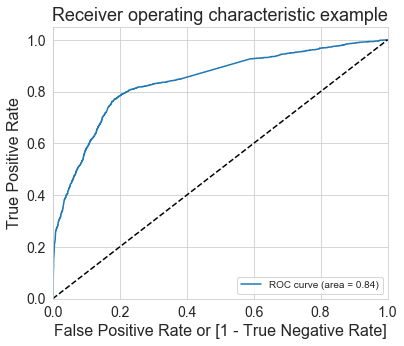

In [181]:
#plot

draw_roc(y_train_pred_df.Converted, y_train_pred_df.Conv_Probability)

***Inference:<br>***
- The curve follows the left-hand border and then the top border of the ROC space,hence the test is accurate.

In [182]:
# Let's create columns with different probability cutoffs 

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_df[i]= y_train_pred_df.Conv_Probability.map(lambda x: 1 if x > i else 0)
y_train_pred_df.head()

Converted  Conv_Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0          0            0.1640          0    1    1    0    0    0    0    0   
1          0            0.1776          0    1    1    0    0    0    0    0   
2          0            0.2129          0    1    1    1    0    0    0    0   
3          0            0.2176          0    1    1    1    0    0    0    0   
4          1            0.4566          0    1    1    1    1    1    0    0   

   0.7  0.8  0.9  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0

In [183]:
#calculate accuracy sensitivity and specificity for various probability cutoffs.

cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in num:
    
    cm1 = metrics.confusion_matrix(y_train_pred_df.Converted, y_train_pred_df[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    
print(cutoff_df)

         prob  accuracy  sensi  speci
0.0000 0.0000    0.3816 1.0000 0.0000
0.1000 0.1000    0.4103 0.9934 0.0506
0.2000 0.2000    0.7427 0.8324 0.6874
0.3000 0.3000    0.7941 0.7821 0.8015
0.4000 0.4000    0.7938 0.7092 0.8460
0.5000 0.5000    0.7815 0.6240 0.8788
0.6000 0.6000    0.7672 0.5313 0.9128
0.7000 0.7000    0.7512 0.4296 0.9497
0.8000 0.8000    0.7240 0.3134 0.9774
0.9000 0.9000    0.6967 0.2142 0.9944


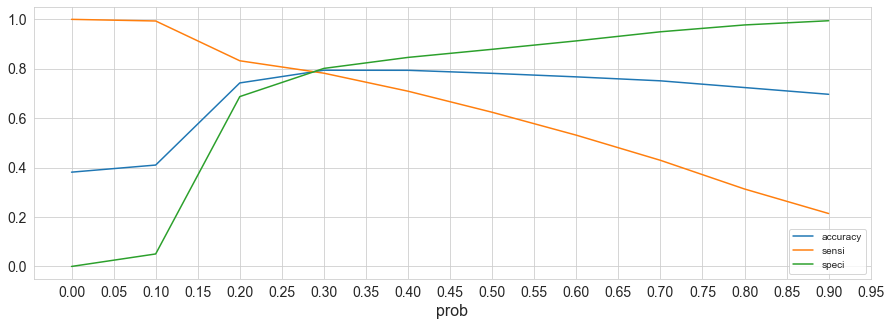

In [184]:
# Let's plot accuracy sensitivity and specificity for various probabilities.

cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(15,5))
plt.xticks(np.arange(0,1,0.05))
plt.show()

***Inference:<br>***
- The optimal cut-off point is 0.29.

In [185]:
y_train_pred_df['final_predicted'] = y_train_pred_df.Conv_Probability.map( lambda x: 1 if x > 0.29 else 0)

y_train_pred_df.head()

Converted  Conv_Probability  Predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0          0            0.1640          0    1    1    0    0    0    0    0   
1          0            0.1776          0    1    1    0    0    0    0    0   
2          0            0.2129          0    1    1    1    0    0    0    0   
3          0            0.2176          0    1    1    1    0    0    0    0   
4          1            0.4566          0    1    1    1    1    1    0    0   

   0.7  0.8  0.9  final_predicted  
0    0    0    0                0  
1    0    0    0                0  
2    0    0    0                0  
3    0    0    0                0  
4    0    0    0                1

In [186]:
# Let's check the overall accuracy.

metrics.accuracy_score(y_train_pred_df.Converted, y_train_pred_df.final_predicted)

0.7922363664937923

In [187]:
confusion3 = metrics.confusion_matrix(y_train_pred_df.Converted, y_train_pred_df.final_predicted)

confusion3

array([[3129,  806],
       [ 516, 1912]], dtype=int64)

In [188]:
TP = confusion3[1,1] # true positive 
TN = confusion3[0,0] # true negatives
FP = confusion3[0,1] # false positives
FN = confusion3[1,0] # false negatives

In [189]:
# sensitivity of our logistic regression model

TP / float(TP+FN)

0.7874794069192751

In [190]:
# specificity

TN / float(TN+FP)

0.795171537484117

In [191]:
# Calculate false postive rate - predicting non_converted customer as converted

print(FP/ float(TN+FP))

0.2048284625158831


In [192]:
# positive predictive value 

print (TP / float(TP+FP))

0.70345842531273


In [193]:
# Negative predictive value

print (TN / float(TN+ FN))

0.8584362139917695


In [194]:
#precision

+.confusion3[1,1]/(confusion3[0,1]+confusion3[1,1]).

0.70345842531273

In [195]:
#recall

confusion3[1,1]/(confusion3[1,0]+confusion3[1,1])

0.7874794069192751

***Inference:<br>***
Metrices on Train data is as follows
- Accuracy based on optimal cut off for final model - 79.2%
- Sensitivity - 78.7%
- Specificity - 79.5%
- Precision - 70.3%
- Recall -  78.7%

In [196]:
from sklearn.metrics import precision_score, recall_score

In [197]:
precision_score(y_train_pred_df.Converted, y_train_pred_df.final_predicted)

0.70345842531273

In [198]:
recall_score(y_train_pred_df.Converted, y_train_pred_df.final_predicted)

0.7874794069192751

In [199]:
from sklearn.metrics import precision_recall_curve

In [200]:
y_train_pred_df.Converted, y_train_pred_df.final_predicted

(0       0
 1       0
 2       0
 3       0
 4       1
 5       0
 6       0
 7       0
 8       1
 9       0
 10      1
 11      0
 12      1
 13      0
 14      0
 15      0
 16      0
 17      1
 18      0
 19      0
 20      1
 21      0
 22      0
 23      0
 24      0
 25      1
 26      1
 27      0
 28      1
 29      0
 30      0
 31      1
 32      0
 33      1
 34      0
 35      1
 36      0
 37      1
 38      0
 39      0
 40      0
 41      1
 42      0
 43      0
 44      1
 45      0
 46      1
 47      0
 48      1
 49      0
 50      0
 51      0
 52      1
 53      0
 54      1
 55      0
 56      0
 57      1
 58      0
 59      0
 60      1
 61      0
 62      1
 63      0
 64      1
 65      0
 66      0
 67      1
 68      0
 69      0
 70      0
 71      1
 72      0
 73      0
 74      0
 75      1
 76      1
 77      1
 78      0
 79      0
 80      1
 81      0
 82      0
 83      1
 84      1
 85      0
 86      0
 87      0
 88      0
 89      1
 90      0

In [201]:
p, r, thresholds = precision_recall_curve(y_train_pred_df.Converted, y_train_pred_df.Conv_Probability)

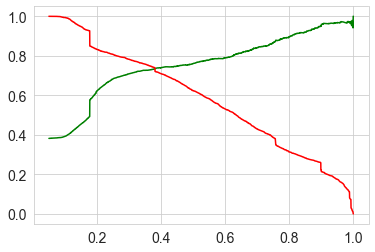

In [202]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Making prediction on test data

In [203]:
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

In [204]:
X_test = X_test[X_train_lm.drop('const',axis=1).columns]

X_test.head()

TotalVisits  Total Time Spent on Website  \
6906       0.2353                       0.6734   
1873       0.1176                       0.0819   
771        0.4118                       0.0216   
4495       0.2353                       0.0634   
9061       0.1176                       0.7870   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
6906                                    1                          0   
1873                                    1                          0   
771                                     0                          0   
4495                                    1                          0   
9061                                    1                          0   

      Lead Source_Olark Chat  Lead Source_Welingak Website  \
6906                       0                             0   
1873                       0                             0   
771                        0                             0   
4495                       0                             0   
9061                       0                             0   

      What is your current occupation_Other  \
6906                                      0   
1873                                      0   
771                                       0   
4495                                      0   
9061                                      0   

      What is your current occupation_Student  \
6906                                        0   
1873                                        0   
771                                         0   
4495                                        0   
9061                                        0   

      What is your current occupation_Unemployed  \
6906                                           1   
1873                                           1   
771                                            1   
4495                                           1   
9061                                           1   

      Specialization_Hospitality Management  Specialization_Others  
6906                                      0                      0  
1873                                      0                      1  
771                                       0                      1  
4495                                      0                      0  
9061                                      0                      0

In [205]:
X_test_sm = sm.add_constant(X_test)

In [206]:
y_test_pred = final.predict(X_test_sm)

In [207]:
y_test_pred[:10]

6906   0.7140
1873   0.0538
771    0.1169
4495   0.1425
9061   0.7877
4929   0.6321
2308   0.1952
1034   0.0862
9033   0.1094
7008   0.7210
dtype: float64

In [208]:
# Converting y_pred to a dataframe which is an array

y_pred_1 = pd.DataFrame(y_test_pred)

In [209]:
# Let's see the head

y_pred_1.head()

0
6906 0.7140
1873 0.0538
771  0.1169
4495 0.1425
9061 0.7877

In [210]:
# Converting y_test to dataframe

y_test_df = pd.DataFrame(y_test)

In [211]:
# Appending y_test_df and y_pred_1

y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [212]:
y_pred_final.head()

Converted      0
6906          1 0.7140
1873          0 0.0538
771           0 0.1169
4495          0 0.1425
9061          1 0.7877

In [213]:
# Renaming the column 

y_pred_final= y_pred_final.rename(columns={ 0 : 'Conv_Probability'})

In [214]:

y_pred_final.head()

Converted  Conv_Probability
6906          1            0.7140
1873          0            0.0538
771           0            0.1169
4495          0            0.1425
9061          1            0.7877

In [215]:
y_pred_final['final_predicted'] = y_pred_final.Conv_Probability.map(lambda x: 1 if x > 0.29 else 0)

In [216]:
y_pred_final.head()

Converted  Conv_Probability  final_predicted
6906          1            0.7140                1
1873          0            0.0538                0
771           0            0.1169                0
4495          0            0.1425                0
9061          1            0.7877                1

In [217]:
# Let's check the overall accuracy.

metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.7887788778877888

In [218]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[1324,  336],
       [ 240,  827]], dtype=int64)

In [219]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [220]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7750702905342081

In [221]:
# Let us calculate specificity
TN / float(TN+FP)

0.7975903614457831

In [222]:
precision_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.711092003439381

In [223]:
recall_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.7750702905342081

***Inference:<br>***
Metrices on Test data is as follows
- Accuracy based on optimal cut off for final model - 78.9%
- Sensitivity - 77.5%
- Specificity - 79.7%
- Precision - 71%
- Recall -  77.5%

### CALCULATING LEAD_SCORE

In [224]:
#creating lead score column

y_pred_final['Lead_Score'] = y_pred_final.Conv_Probability * 100

y_pred_final.head()

Converted  Conv_Probability  final_predicted  Lead_Score
6906          1            0.7140                1     71.4011
1873          0            0.0538                0      5.3763
771           0            0.1169                0     11.6909
4495          0            0.1425                0     14.2493
9061          1            0.7877                1     78.7670

In [225]:
y_pred_final.Lead_Score.describe()

count   2727.0000
mean      38.4759
std       29.2865
min        4.1522
25%       16.5852
50%       20.6303
75%       62.3974
max       99.9757
Name: Lead_Score, dtype: float64

In [226]:
y_pred_final.groupby(by="Converted")['Lead_Score'].describe()

count    mean     std    min     25%     50%     75%     max
Converted                                                                 
0         1660.0000 24.3678 18.6386 4.1522 13.8295 17.7552 22.9947 99.8362
1         1067.0000 60.4249 29.3347 7.6050 35.2124 64.0110 89.8454 99.9757

### INFERENCE ON LEAD_SCORE

- it can be concluded from the above model that, higher the lead_score value, higher are the chances for the individual to convert.
- from the statistical description above, it can be identified that the converted group has a mean score of 60%. 
- Therefore, a score of 60% or above is desired.

*** ****  ****** ****** **********  ********* ***********************

## `FINAL SCORES`

***Precision Score on TRAIN data:*** 
- 0.7034

***Precision Score on TEST data:*** 
- 0.7110

***Recall Score on TRAIN data:*** 
- 0.7874

***Recall Score on TEST data:*** 
- 0.7750

## Final Model

The equation of the best fitted model is as follows <br>

***Conversion = 1.2297  +    4.4418 x Total Time Spent on Website +  3.631 x Lead Origin_Lead Add Form  +   3.2687 x Lead Source_Welingak Website +  0.9215 x TotalVisits  +  0.9642 x Lead Source_Olark Chat  - 0.8427 x Lead Origin_Landing Page Submission   -  1.0469 x Specialization_Others -  0.8103 x Specialization_Hospitality Management -  2.5099 x What is your current occupation_Other -  2.5512 x What is your current occupation_Student - 2.6801 x What is your current occupation_Unemployed***

### Top 5 features that define the target variable
1. Total Time Spent on Website
2. Lead Origin_Lead Add Form
3. Lead Source_Welingak Website
4. Total Visits
5. Lead Source_Olark Chat 

***The following variables are directly propotional to the 'Converted' variable***
1. Total Time Spent on Website
2. Lead Origin_Lead Add Form
3. Lead Source_Welingak Website
4. Total Visits
5. Lead Source_Olark Chat 

***The following variables are inversely propotional to the 'converted' variable***
1. Lead Origin_Landing Page Submission
2. Specialization_Others
3. What is your current occupation_Other
4. what is your current occupation_Student
5. What is your current occupation_Unemployed
6. Specialization_hospitality Management

### Conclusions :

- Customers who spent more time on website are more likely to convert. (Time Spent on Website)
- Customers whose lead origin is lead add form are more likely to convert than other categories.
- Customers whose lead origin is Landing page Submission are less likely to convert.
- Student and unemployed individuals are less likely to convert.
- The more times the customer visit the website,the more likely he is to enroll. (TotalVisits)
- Customers whose lead source is Olark chat seems to have converted a lot.
- Customers with specialization as 'Others' hardly enroll.
- Customers whose source is Welingak Website are likely to converts more.
- A LEAD SCORE OF ATLEAST 60% IS DESIRED.